In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Load and clean data
df = pd.read_csv("Fbref_2023_2.csv", encoding='latin1')
df.columns = df.columns.str.strip()

In [4]:
# Handle missing values
print(f'Initial Missing Values:\n{df.isnull().sum()}')

Initial Missing Values:
Rk                   0
Edited Name          0
Original Name        0
Matching Name        0
Market Value Euro    7
Nation               0
Pos                  0
Squad                0
Comp                 0
Born                 0
MP                   0
90s                  0
Goals                0
Goals Per Match      0
Shots                0
SoT                  0
G/Sh                 0
G/SoT                0
ShoDist              0
ShoFK                0
ShoPK                0
PKatt                0
PasTotCmp            0
PasTotAtt            0
PasTotDist           0
PasTotPrgDist        0
PasShoCmp            0
PasShoAtt            0
PasMedCmp            0
PasMedAtt            0
PasLonCmp            0
PasLonAtt            0
Assists              0
PasAss               0
Pas3rd               0
PPA                  0
CrsPA                0
PasProg              0
PasLive              0
PasDead              0
PasFK                0
TB                   0
Sw        

In [5]:
# Clean 'Market Value Euro' column
df['Market Value Euro'] = df['Market Value Euro'].str.replace(',', '')
df['Market Value Euro'] = pd.to_numeric(df['Market Value Euro'], errors='coerce').fillna(0).astype(int)

In [6]:
# Replace missing values in 'Market Value Euro' with median for robustness
market_value_median = df[df['Market Value Euro'] > 0]['Market Value Euro'].median()
df['Market Value Euro'] = df['Market Value Euro'].replace(0, market_value_median)

In [7]:
# Verify missing values
print(f'Post-Cleaning Missing Values:\n{df.isnull().sum()}')

Post-Cleaning Missing Values:
Rk                   0
Edited Name          0
Original Name        0
Matching Name        0
Market Value Euro    0
Nation               0
Pos                  0
Squad                0
Comp                 0
Born                 0
MP                   0
90s                  0
Goals                0
Goals Per Match      0
Shots                0
SoT                  0
G/Sh                 0
G/SoT                0
ShoDist              0
ShoFK                0
ShoPK                0
PKatt                0
PasTotCmp            0
PasTotAtt            0
PasTotDist           0
PasTotPrgDist        0
PasShoCmp            0
PasShoAtt            0
PasMedCmp            0
PasMedAtt            0
PasLonCmp            0
PasLonAtt            0
Assists              0
PasAss               0
Pas3rd               0
PPA                  0
CrsPA                0
PasProg              0
PasLive              0
PasDead              0
PasFK                0
TB                   0
Sw  

In [8]:
df.head()

,Rk,Edited Name,Original Name,Matching Name,Market Value Euro,Nation,Pos,Squad,Comp,Born,MP,90s,Goals,Goals Per Match,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
0,1,Brenden Aaronson,Brenden Aaronson,Brenden Aaronson,25000000,USA,MF,Leeds United,Premier League,2000,20,17.7,1,0.05,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19
1,2,Yunis Abdelhamid,Yunis Abdelhamid,Yunis Abdelhamid,700000,MAR,DF,Reims,Ligue 1,1987,22,22.0,0,-,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23
2,3,Himad Abdelli,Himad Abdelli,Himad Abdelli,2500000,FRA,MF,Angers,Ligue 1,1999,14,8.6,0,-,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05
3,4,Salis Abdul Samed,Salis Abdul Samed,Salis Abdul Samed,13000000,GHA,MF,Lens,Ligue 1,2000,20,20.0,1,0.05,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50
4,5,Laurent Abergel,Laurent Abergel,Laurent Abergel,3000000,FRA,MF,Lorient,Ligue 1,1993,15,12.9,0,-,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39


In [9]:
df.describe()

,Rk,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost
count,2442.000000,2.442000e+03,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.00000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000,2442.000000
mean,1324.375102,1.118568e+07,1996.330467,11.869369,8.264087,1.104423,1.330631,0.443612,0.068911,0.179005,15.185053,0.038800,0.008403,0.011462,33.976331,43.307928,571.371335,179.448014,16.096941,18.64459,13.756241,16.506405,2.960885,5.242219,0.088530,0.930528,2.658812,0.796441,0.214046,3.563423,39.518857,3.612158,0.901552,0.117318,0.331241,1.778943,1.966839,0.445012,0.188984,0.170749,0.003391,33.976331,0.176585,0.972899,2.198485,1.586884,0.178567,0.119521,0.160479,0.11464,0.038436,0.222416,0.152027,0.011052,0.015049,0.027707,0.013673,0.002912,1.816425,1.05645,0.867617,0.693640,0.255213,0.797666,1.533747,0.736003,1.152228,0.292789,0.859562,0.871716,1.643837,0.019521,54.790377,2.917985,14.342695,25.826912,15.218153,2.314869,54.778747,1.918600,0.765340,0.910852,32.288202,174.633018,83.667793,1.786650,1.355287,0.466048,1.774869,1.114959,35.528288,4.227203,0.254083,0.017776,0.007322,1.385459,1.203628,0.220315,1.778943,1.05645,0.010008,0.015262,0.003108,5.189902,1.374541,1.593821
std,778.250236,1.633751e+07,4.351341,6.768282,6.364620,2.074244,1.428985,0.779610,0.122111,0.267803,8.092930,0.207546,0.040666,0.051811,17.410455,18.886052,330.940994,121.803843,8.303252,8.70362,9.385421,9.891819,2.642681,3.859972,0.282853,1.095796,2.188480,1.092908,0.539694,2.517976,17.751095,3.787436,1.095920,0.398575,0.586980,2.362002,3.405369,1.117561,0.669826,0.525090,0.030025,17.410455,0.416665,1.088265,1.895857,1.428765,0.499852,0.464115,0.477930,0.27421,0.164184,0.475926,0.351678,0.055001,0.142740,0.260786,0.057264,0.024733,1.737980,1.25410,1.181219,0.929353,0.589007,1.018922,1.524399,0.981666,1.195067,0.495496,1.114037,0.878527,1.740125,0.065221,19.295595,3.163739,11.142585,12.474453,10.248563,2.515421,19.300294,2.264234,1.199748,1.280282,14.148413,96.267585,57.622085,1.942555,1.543943,0.890674,1.859116,1.535594,15.111736,4.126963,0.599642,0.235879,0.114240,1.431151,1.235570,0.573939,2.362002,1.25410,0.045635,0.078134,0.021258,2.812007,1.570325,1.860780

In [10]:
# Encode with LabelEncoder
le = LabelEncoder()
df['Pos_Cat'] = le.fit_transform(df['Pos'])
df['Nation_Cat'] = le.fit_transform(df['Nation'])
df['Squad_Cat'] = le.fit_transform(df['Squad'])
df['Comp_Cat'] = le.fit_transform(df['Comp'])

In [11]:
df.head()

,Rk,Edited Name,Original Name,Matching Name,Market Value Euro,Nation,Pos,Squad,Comp,Born,MP,90s,Goals,Goals Per Match,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,1,Brenden Aaronson,Brenden Aaronson,Brenden Aaronson,25000000,USA,MF,Leeds United,Premier League,2000,20,17.7,1,0.05,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,2,98,44,3
1,2,Yunis Abdelhamid,Yunis Abdelhamid,Yunis Abdelhamid,700000,MAR,DF,Reims,Ligue 1,1987,22,22.0,0,-,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,0,64,73,2
2,3,Himad Abdelli,Himad Abdelli,Himad Abdelli,2500000,FRA,MF,Angers,Ligue 1,1999,14,8.6,0,-,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,2,36,2,2
3,4,Salis Abdul Samed,Salis Abdul Samed,Salis Abdul Samed,13000000,GHA,MF,Lens,Ligue 1,2000,20,20.0,1,0.05,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,2,41,46,2
4,5,Laurent Abergel,Laurent Abergel,Laurent Abergel,3000000,FRA,MF,Lorient,Ligue 1,1993,15,12.9,0,-,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,2,36,50,2


In [12]:
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

In [13]:
numeric_df.head()

,Rk,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,1,25000000,2000,20,17.7,1,1.53,0.28,0.04,0.20,19.0,0.11,0.0,0.0,23.2,31.0,293.0,85.7,13.3,16.2,5.93,7.74,0.90,2.37,0.11,1.75,1.75,0.45,0.11,3.22,28.1,2.88,0.96,0.17,0.00,2.54,0.23,1.47,0.68,0.62,0.06,23.2,0.00,0.85,3.62,2.37,0.56,0.23,0.11,0.28,0.06,0.28,0.17,0.0,0.0,0.06,0.0,0.06,1.64,0.51,0.45,0.90,0.28,0.51,1.47,0.96,1.69,0.11,1.58,0.06,0.28,0.06,44.0,0.40,4.35,19.0,21.50,2.49,44.0,3.73,1.19,1.75,26.7,136.1,56.6,1.53,1.07,0.40,2.60,3.11,30.2,5.65,0.11,0.0,0.0,0.62,2.26,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,2,98,44,3
1,2,700000,1987,22,22.0,0,0.86,0.05,0.00,0.00,13.5,0.00,0.0,0.0,38.5,47.2,751.5,318.5,10.9,12.9,23.20,25.70,3.77,7.00,0.05,0.27,2.91,0.09,0.00,4.50,43.3,3.73,3.32,0.00,0.55,0.18,0.09,0.00,0.00,0.00,0.00,38.5,0.23,0.59,1.14,0.86,0.00,0.00,0.18,0.00,0.09,0.18,0.14,0.0,0.0,0.05,0.0,0.00,2.50,1.59,1.45,1.00,0.05,1.32,1.68,0.36,2.23,0.77,1.45,2.00,2.91,0.05,59.2,6.23,27.50,29.5,2.73,1.09,59.2,0.68,0.32,0.36,40.0,234.2,125.0,0.55,0.23,0.09,0.73,0.68,34.5,0.23,0.09,0.0,0.0,1.32,0.50,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,0,64,73,2
2,3,2500000,1999,14,8.6,0,1.05,0.35,0.00,0.00,19.2,0.00,0.0,0.0,40.0,49.5,676.0,188.1,18.5,22.0,15.50,18.70,4.42,5.93,0.00,1.51,3.95,1.74,0.35,6.40,48.1,1.16,0.35,0.12,0.23,1.05,0.81,0.00,0.00,0.00,0.00,40.0,0.23,1.16,2.67,2.44,0.00,0.00,0.12,0.00,0.12,0.00,0.00,0.0,0.0,0.00,0.0,0.00,2.91,1.40,1.28,1.40,0.23,1.63,2.67,1.05,1.51,0.12,1.40,0.93,0.93,0.00,62.6,0.93,11.40,36.0,17.40,1.16,62.6,3.84,2.09,1.51,48.5,298.5,151.0,2.56,2.56,0.47,2.09,1.05,43.4,5.93,0.12,0.0,0.0,1.74,1.28,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,2,36,2,2
3,4,13000000,2000,20,20.0,1,0.60,0.15,0.08,0.33,20.3,0.00,0.0,0.0,59.5,64.9,946.3,226.9,29.6,31.8,24.70,26.20,3.35,4.30,0.00,0.50,6.00,0.55,0.10,5.60,63.1,1.40,1.30,0.05,0.20,0.35,0.10,0.00,0.00,0.00,0.00,59.5,0.35,0.40,1.60,1.35,0.00,0.10,0.10,0.00,0.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,1.50,0.80,0.55,0.85,0.10,0.85,1.30,0.45,1.30,0.35,0.95,1.10,0.80,0.00,73.3,2.10,12.00,49.6,12.20,0.70,73.3,1.25,0.70,0.40,61.0,316.9,117.5,1.25,1.95,0.15,1.35,1.30,56.5,1.70,0.15,0.0,0.0,2.45,1.35,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,2,41,46,2
4,5,3000000,1993,15,12.9,0,0.31,0.00,0.00,0.00,23.9,0.00,0.0,0.0,37.9,43.4,613.6,224.7,17.9,19.4,15.70,17.80,2.64,3.95,0.08,0.62,3.88,0.39,0.00,5.04,42.6,0.78,0.78,0.39,0.16,0.23,0.00,0.00,0.00,0.00,0.00,37.9,0.08,0.31,1.24,1.01,0.08,0.00,0.08,0.00,0.08,0.08,0.08,0.0,0.0,0.00,0.0,0.00,3.80,2.02,2.64,1.16,0.00,1.32,3.26,1.94,1.40,0.23,1.16,1.16,1.55,0.00,54.7,3.26,19.20,31.4,4.88,0.23,54.7,0.93,0.54,0.31,41.0,174.3,72.7,0.47,0.93,0.00,1.32,0.78,36.4,0.47,0.16,0.0,0.0,0.93,1.01,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,2,36,50,2


In [14]:
# Scale features using RobustScaler
scaler = RobustScaler()
features_to_scale = numeric_df.drop(columns=['Pos_Cat','Nation_Cat','Squad_Cat','Comp_Cat'])
scaled_features = scaler.fit_transform(features_to_scale)
scaled_numeric_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# # Save the scaler
# joblib.dump(scaler, 'robust_scaler.pkl')

In [15]:
# Shift the scaled data to ensure no negative values
min_value = scaled_features.min()
shifted_scaled_features = scaled_features - min_value

In [16]:
# Convert back to DataFrame
scaled_numeric_df = pd.DataFrame(shifted_scaled_features, columns=features_to_scale.columns)

In [17]:
# Add non-scaled columns
# scaled_numeric_df['Market Value Euro'] = df['Market Value Euro']
scaled_numeric_df['Pos_Cat'] = df['Pos_Cat']
scaled_numeric_df['Nation_Cat'] = df['Nation_Cat']
scaled_numeric_df['Squad_Cat'] = df['Squad_Cat']
scaled_numeric_df['Comp_Cat'] = df['Comp_Cat']

In [18]:
# Drop 'Rk' if exists in the dataset
if 'Rk' in scaled_numeric_df.columns:
    scaled_numeric_df = scaled_numeric_df.drop('Rk', axis=1)

In [19]:
scaled_numeric_df.head()

,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
0,4.061404,2.823308,2.933198,3.297392,3.394737,2.755496,2.472862,2.758373,3.000797,2.720580,2.504737,2.394737,2.394737,1.960646,1.902557,1.826385,1.935824,2.209170,2.234737,1.855241,1.749808,1.894737,1.934661,3.311404,3.295638,2.159320,2.262084,2.787594,2.353692,1.903090,2.573721,2.653478,3.702429,2.054311,3.052658,2.369259,10.131579,3.074737,3.014737,2.454737,1.960646,2.019737,2.416242,3.180114,3.012623,6.702429,4.485646,2.973684,4.293042,2.454737,2.957237,2.894737,2.394737,2.394737,2.454737,2.394737,2.454737,2.429702,1.995815,2.142105,2.896479,2.818979,2.228070,2.503264,2.942682,3.232237,2.323308,3.603070,1.720038,1.977237,2.454737,1.929825,1.929233,1.895959,1.986866,2.910610,2.752670,1.929825,3.481546,3.207924,3.394737,2.155743,2.155889,2.067622,2.495747,2.387792,2.820966,3.087474,4.257640,2.181322,2.733389,2.261404,2.394737,2.394737,1.864737,3.498185,3.103070,3.052658,1.995815,2.394737,2.394737,2.394737,2.310446,1.926205,2.410737,2,98,44,3
1,2.036404,0.966165,3.087045,3.677923,2.394737,2.331446,2.113487,2.394737,2.394737,2.102602,2.394737,2.394737,2.394737,2.656100,2.578261,2.865832,3.271261,1.961747,1.904737,3.306502,3.186895,2.791612,2.814889,2.811404,1.962304,2.642654,1.894737,2.394737,2.831304,2.628627,2.770026,4.303828,2.394737,3.224524,2.100085,2.280087,2.394737,2.394737,2.394737,2.394737,2.656100,2.978070,2.136672,2.010303,2.030509,2.394737,2.394737,3.342105,2.394737,2.484737,2.644737,2.758373,2.394737,2.394737,2.444737,2.394737,2.394737,3.031100,3.160235,3.194737,3.035852,2.122010,3.192356,2.666055,2.120764,3.907237,3.894737,3.422515,3.589918,3.292237,2.444737,2.596491,3.697239,3.405332,2.738207,1.420927,2.236065,2.596491,2.106124,2.251880,2.226670,2.992221,3.082016,3.254607,2.000797,1.804459,2.312770,2.042782,2.297963,2.443517,1.772396,2.194737,2.394737,2.394737,2.564737,1.980944,2.603070,2.100085,3.160235,2.394737,2.394737,2.394737,2.992438,3.212919,2.442737,0,64,73,2
2,2.186404,2.680451,2.471660,2.492082,2.394737,2.451699,2.582237,2.394737,2.394737,2.743051,2.394737,2.394737,2.394737,2.724282,2.674195,2.694669,2.523232,2.745252,2.814737,2.659443,2.626783,2.994737,2.611467,2.394737,3.079422,3.075987,3.578410,3.644737,3.540259,2.857744,2.176492,2.226905,3.317814,2.543673,2.451245,2.738686,2.394737,2.394737,2.394737,2.394737,2.724282,2.978070,2.749576,2.732001,3.058151,2.394737,2.394737,3.026316,2.394737,2.514737,2.082237,2.122010,2.394737,2.394737,2.394737,2.394737,2.394737,3.317814,2.955384,3.015789,3.593343,2.667464,3.561404,3.433497,3.065970,3.007237,2.347118,3.353070,2.558592,2.302237,2.394737,2.745614,2.089960,2.355617,3.203324,2.585213,2.261896,2.745614,3.531152,4.196935,3.193056,3.526812,3.689049,3.705800,3.015949,3.422515,2.935720,2.802558,2.596350,2.986200,2.783035,2.294737,2.394737,2.394737,2.984737,2.653358,2.394737,2.451245,2.955384,2.394737,2.394737,2.394737,3.567151,2.338793,2.298737,2,36,2,2
3,3.061404,2.823308,2.933198,3.500932,3.394737,2.166889,2.269737,3.122010,3.394737,2.866647,2.394737,2.394737,2.394737,3.610646,3.316530,3.307455,2.745805,3.889582,3.794737,3.432552,3.226903,2.660362,2.301581,2.394737,2.169512,3.930154,2.364125,2.751880,3.241752,3.573734,2.231919,2.891240,2.779352,2.479843,2.168703,2.286457,2.394737

In [20]:
# Check which columns contain negative values
negative_columns = scaled_numeric_df.apply(lambda col: col[col < 0].count() > 0)

In [21]:
print("Columns with negative values:")
print(negative_columns[negative_columns == True].index.tolist())

Columns with negative values:
[]


In [22]:
# Check unique values in 'pos' column
unique_pos = df['Pos'].unique()
print("Unique values in 'pos':")
print(unique_pos)

Unique values in 'pos':
['MF' 'DF' 'FW']


In [23]:
# Check unique values in 'pos_cat' column
unique_pos_cat = df['Pos_Cat'].unique()
print("Unique values in 'pos_cat':")
print(unique_pos_cat)

Unique values in 'pos_cat':
[2 0 1]


In [24]:
# Create a mapping between 'pos' and 'pos_cat'
pos_mapping = df[['Pos', 'Pos_Cat']].drop_duplicates().sort_values(by='Pos_Cat').reset_index(drop=True)

print("Mapping between 'pos' and 'pos_cat':")
print(pos_mapping)

Mapping between 'pos' and 'pos_cat':
  Pos  Pos_Cat
0  DF        0
1  FW        1
2  MF        2


In [25]:
df['Pos_Cat'].value_counts()

Pos_Cat
0    934
2    846
1    662
Name: count, dtype: int64

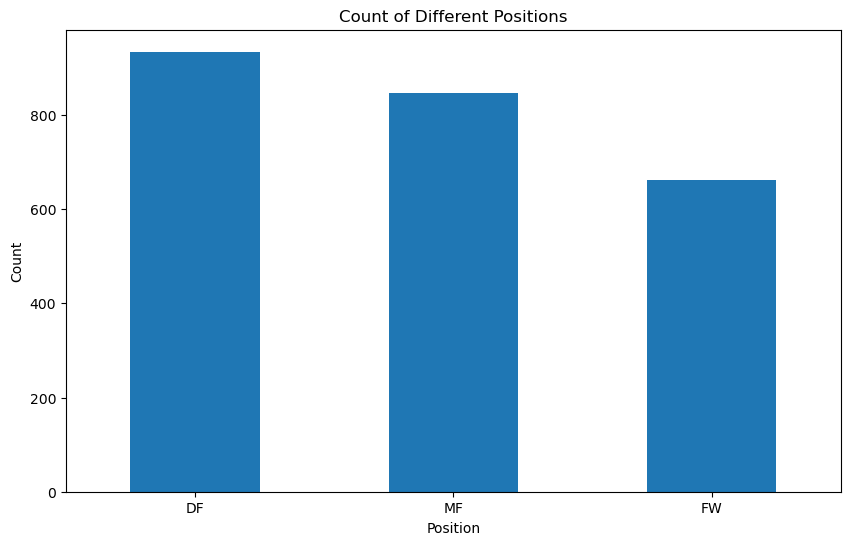

In [26]:
# Plot histogram count of positions
plt.figure(figsize=(10, 6))
df['Pos'].value_counts().plot(kind='bar')
plt.title('Count of Different Positions')
plt.xlabel('Position')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

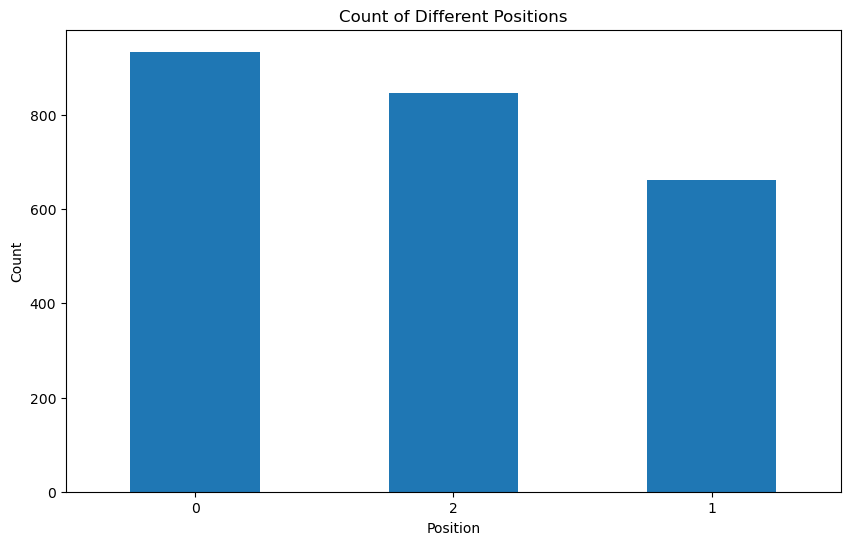

In [27]:
# Plot histogram count of positions
plt.figure(figsize=(10, 6))
scaled_numeric_df['Pos_Cat'].value_counts().plot(kind='bar')
plt.title('Count of Different Positions')
plt.xlabel('Position')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

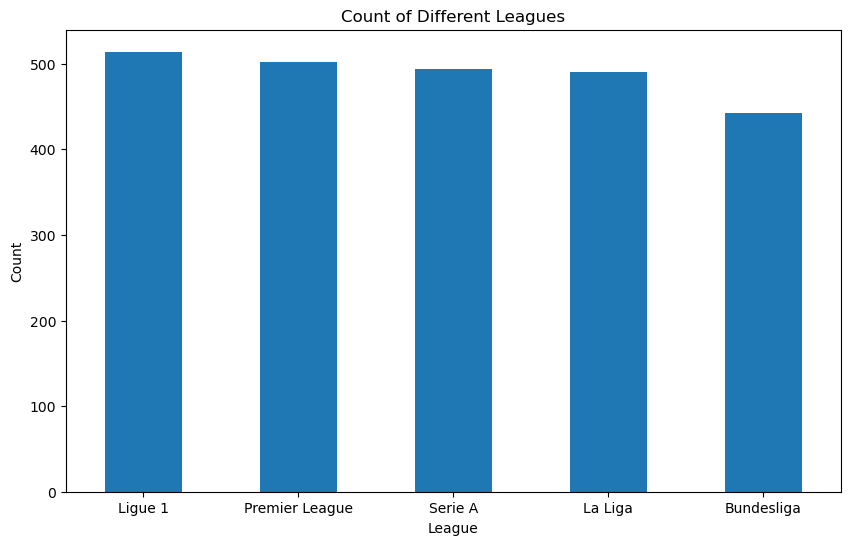

In [28]:
# Plot histogram count of positions
plt.figure(figsize=(10, 6))
df['Comp'].value_counts().plot(kind='bar')
plt.title('Count of Different Leagues')
plt.xlabel('League')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [29]:
# Calculate correlation matrix
correlation_matrix = scaled_numeric_df.corr()

# Print correlation matrix
correlation_matrix

,Market Value Euro,Born,MP,90s,Goals,Shots,SoT,G/Sh,G/SoT,ShoDist,ShoFK,ShoPK,PKatt,PasTotCmp,PasTotAtt,PasTotDist,PasTotPrgDist,PasShoCmp,PasShoAtt,PasMedCmp,PasMedAtt,PasLonCmp,PasLonAtt,Assists,PasAss,Pas3rd,PPA,CrsPA,PasProg,PasLive,PasDead,PasFK,TB,Sw,PasCrs,TI,CK,CkIn,CkOut,CkStr,PasCmp,PasOff,PasBlocks,SCA,ScaPassLive,ScaPassDead,ScaDrib,ScaSh,ScaFld,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaFld,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,TklDriAtt,TklDriPast,Blocks,BlkSh,BlkPass,Int,Clr,Err,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,TouLive,ToAtt,ToSuc,ToTkl,Carries,CarTotDist,CarPrgDist,CarProg,Car3rd,CPA,CarMis,CarDis,Rec,RecProg,CrdY,CrdR,2CrdY,Fls,Fld,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,Pos_Cat,Nation_Cat,Squad_Cat,Comp_Cat
Market Value Euro,1.000000,0.139496,0.286923,0.339961,0.447905,0.138930,0.114982,0.144634,0.175860,0.103496,0.026574,0.126360,0.119067,0.152422,0.128769,0.118394,0.054653,0.192930,0.187349,0.089783,0.069318,0.051397,0.004786,0.094695,0.124825,0.141933,0.105950,-0.014645,0.126414,0.149271,-0.059583,-0.000013,0.095428,0.078359,-0.013871,-0.095378,0.060601,0.046472,0.032884,0.056888,0.152422,0.017317,0.003232,0.148642,0.147273,0.013270,0.047312,0.056478,0.047278,0.017430,0.123224,0.128193,0.034787,0.027716,0.014368,0.060754,0.026303,-0.063769,-0.046029,-0.080045,-0.018729,0.001787,-0.058137,-0.073487,-0.053830,-0.044953,-0.049256,-0.026375,-0.050954,-0.082104,0.004310,0.124593,-0.040529,-0.032732,0.102965,0.147748,0.173641,0.124255,0.100859,0.098222,0.064376,0.164953,0.151999,0.156601,0.128300,0.087597,0.161449,0.015450,0.025661,0.216255,0.120362,-0.047486,-0.016429,-0.005454,-0.073757,0.031064,0.029053,-0.013871,-0.046029,0.061557,-0.049369,0.038228,-0.016515,-0.060702,-0.104235,0.057258,-0.014103,-0.020786,0.082831
Born,0.139496,1.000000,-0.219287,-0.217304,-0.084163,0.048642,0.054472,-0.036739,-0.082920,-0.110296,-0.048457,-0.105874,-0.127398,-0.100614,-0.107997,-0.123007,-0.171264,-0.054289,-0.049524,-0.089243,-0.094921,-0.159137,-0.175395,0.012677,-0.033262,-0.140688,0.004268,0.016811,-0.084007,-0.097215,-0.076404,-0.168581,-0.035886,-0.093729,-0.025600,-0.002079,-0.055505,-0.026514,-0.053225,-0.047274,-0.100614,-0.058236,0.057462,0.015745,0.005904,-0.064729,0.080218,0.018640,0.015538,0.021442,0.036713,0.027021,-0.046472,0.021473,0.026961,0.004662,0.007615,0.101689,0.095614,0.063014,0.066310,0.069226,0.021690,0.031188,0.026043,0.042433,-0.088285,0.084789,0.002044,-0.112367,-0.000091,-0.062422,-0.123527,-0.087828,-0.074567,0.074987,0.070913,-0.062047,0.213889,0.152022,0.191722,-0.014245,0.073199,0.043913,0.118538,0.066069,0.133708,0.137467,0.163235,-0.057076,0.114659,0.037254,-0.015672,-0.001606,0.060290,0.059450,-0.036435,-0.025600,0.095614,0.028498,0.004077,-0.017087,0.042172,-0.065115,0.032218,0.063239,0.032719,0.058844,0.019184
MP,0.286923,-0.219287,1.000000,0.902420,0.429168,0.007898,0.010656,0.186783,0.319424,0.416243,0.021592,0.131650,0.132473,0.080269,0.071698,0.089369,0.105057,0.072729,0.066234,0.054403,0.050776,0.109708,0.099012,0.049261,0.053634,0.150813,0.018721,-0.016391,0.108769,0.068253,0.038052,0.106641,0.014790,0.068318,0.007866,-0.020039,0.059094,0.030133,0.050810,0.063162,0.080269,-0.005893,-0.037485,0.039512,0.058512,0.046364,-0.037763,-0.038077,0.015800,-0.003218,0.050016,0.068842,0.090817,-0.014629,-0.036997,0.083747,0.065143,-0.089202,-0.084074,-0.087999,-0.027413,-0.043588,-0.041572,-0.078187,-0.078408,-0.051998,-0.001319,-0.055274,0.021830,-0.020064,-0.000476,0.036141,0.008287,0.011816,0.068585,-0.028527,-0.009606,0.035765,-0.087579,-0.072909,-0.071425,0.060210,0.034872,0.043405,-0.016370,-0.021261,0.006910,-0.083156,-0.097736,0.064521,-0.040791,-0.099104,-0.042121,-0.042028,-0.110766,-0.009883,-0.032809,0.007866,-0.084074,0.086043,-0.016285,0.036022,0.004320,-0.039973,-0.126331,0.019049,-0.001515,-0.015897,0.041182
90s,0.339961,-0.217304,0.902420,1.000000,0.423576,-0.085998,-0.048441,0.161682,0.286378,0.339776,0.016248,0

In [30]:
import numpy as np
import pandas as pd

# Sample data: scaled_numeric_df is your dataframe with scaled numeric features

# Set the threshold for collinearity
threshold = 0.95

# Compute the correlation matrix
corr_matrix = scaled_numeric_df.corr().abs()

# Initialize the set of columns to keep
columns_to_keep = set(scaled_numeric_df.columns)

# Loop through the correlation matrix and identify columns to drop
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            # Check which column to drop based on the current set of columns to keep
            if colname_i in columns_to_keep and colname_j in columns_to_keep:
                # Drop one of the columns (e.g., column j)
                columns_to_keep.remove(colname_j)

# Create a new dataframe with only the selected columns
scaled_numeric_df = scaled_numeric_df[list(columns_to_keep)]

# Output the result
print(f"Dropped columns due to high correlation: {set(scaled_numeric_df.columns) - columns_to_keep}")
print(f"Remaining columns: {columns_to_keep}")

Dropped columns due to high correlation: set()
Remaining columns: {'TklDriAtt', 'PasOff', 'PKatt', 'CrdR', 'ToSuc', 'GCA', 'Clr', 'PasLonCmp', 'Touches', 'ToAtt', 'Fls', 'CPA', '90s', 'GcaPassDead', 'ScaDrib', 'Fld', '2CrdY', 'Pas3rd', 'Pos_Cat', 'PasTotPrgDist', 'ScaPassLive', 'OG', 'ScaSh', 'PasMedCmp', 'AerLost', 'Tkl', 'TouDefPen', 'Err', 'RecProg', 'AerWon', 'TouMid3rd', 'MP', 'ScaDef', 'Int', 'GcaFld', 'TouAttPen', 'CrdY', 'BlkPass', 'PasTotCmp', 'GcaPassLive', 'G/Sh', 'Carries', 'G/SoT', 'PasDead', 'GcaDef', 'PPA', 'TklAtt3rd', 'ShoDist', 'CrsPA', 'SoT', 'TI', 'CarTotDist', 'TouDef3rd', 'TklWon', 'PKcon', 'TB', 'Squad_Cat', 'PKwon', 'Comp_Cat', 'CarMis', 'PasFK', 'TklDef3rd', 'CK', 'GcaSh', 'CkOut', 'TklDri', 'PasShoCmp', 'ShoFK', 'GcaDrib', 'ScaFld', 'PasCrs', 'ToTkl', 'Born', 'TouAtt3rd', 'PasBlocks', 'CarDis', 'CkIn', 'Car3rd', 'PasProg', 'PasAss', 'Assists', 'TklMid3rd', 'BlkSh', 'TklDriPast', 'Blocks', 'CarPrgDist', 'PasLonAtt', 'CkStr', 'Off', 'Rec', 'Shots', 'Nation_Cat',

In [31]:
scaled_numeric_df.head()

,TklDriAtt,PasOff,PKatt,CrdR,ToSuc,GCA,Clr,PasLonCmp,Touches,ToAtt,Fls,CPA,90s,GcaPassDead,ScaDrib,Fld,2CrdY,Pas3rd,Pos_Cat,PasTotPrgDist,ScaPassLive,OG,ScaSh,PasMedCmp,AerLost,Tkl,TouDefPen,Err,RecProg,AerWon,TouMid3rd,MP,ScaDef,Int,GcaFld,TouAttPen,CrdY,BlkPass,PasTotCmp,GcaPassLive,G/Sh,Carries,G/SoT,PasDead,GcaDef,PPA,TklAtt3rd,ShoDist,CrsPA,SoT,TI,CarTotDist,TouDef3rd,TklWon,PKcon,TB,Squad_Cat,PKwon,Comp_Cat,CarMis,PasFK,TklDef3rd,CK,GcaSh,CkOut,TklDri,PasShoCmp,ShoFK,GcaDrib,ScaFld,PasCrs,ToTkl,Born,TouAtt3rd,PasBlocks,CarDis,CkIn,Car3rd,PasProg,PasAss,Assists,TklMid3rd,BlkSh,TklDriPast,Blocks,CarPrgDist,PasLonAtt,CkStr,Off,Rec,Shots,Nation_Cat,Goals,Sw,SCA,CarProg,Recov,ScaPassDead,Market Value Euro,ShoPK
0,2.503264,2.019737,2.394737,2.394737,3.207924,2.957237,1.977237,1.894737,1.929825,3.481546,1.864737,2.820966,3.297392,2.394737,4.485646,3.498185,2.394737,2.159320,2,1.935824,3.012623,2.394737,2.973684,1.855241,2.410737,2.429702,1.929233,2.454737,2.733389,1.926205,1.986866,2.933198,2.454737,1.720038,2.394737,2.752670,2.261404,3.603070,1.960646,2.894737,2.758373,2.155743,3.000797,2.573721,2.454737,2.262084,2.818979,2.720580,2.787594,2.472862,2.369259,2.155889,1.895959,1.995815,2.394737,3.702429,44,2.394737,3,3.087474,2.653478,2.142105,10.131579,2.454737,3.014737,2.228070,2.209170,2.504737,2.394737,4.293042,3.052658,3.394737,2.823308,2.910610,2.416242,4.257640,3.074737,2.387792,2.353692,3.295638,3.311404,2.896479,2.323308,2.942682,3.232237,2.067622,1.934661,2.454737,3.103070,2.181322,2.755496,98,3.394737,2.054311,3.180114,2.495747,2.310446,6.702429,4.061404,2.394737
1,2.666055,2.978070,2.394737,2.394737,2.251880,2.644737,3.292237,2.791612,2.596491,2.106124,2.564737,2.312770,3.677923,2.394737,2.394737,1.980944,2.394737,2.642654,0,3.271261,2.030509,2.394737,3.342105,3.306502,2.442737,3.031100,3.697239,2.444737,1.772396,3.212919,2.738207,3.087045,2.484737,3.589918,2.394737,2.236065,2.194737,3.422515,2.656100,2.758373,2.394737,2.992221,2.394737,2.770026,2.394737,1.894737,2.122010,2.102602,2.394737,2.113487,2.280087,3.082016,3.405332,3.160235,2.394737,2.394737,73,2.394737,2,2.042782,4.303828,3.194737,2.394737,2.444737,2.394737,3.192356,1.961747,2.394737,2.394737,2.394737,2.100085,2.226670,0.966165,1.420927,2.136672,2.297963,2.394737,1.804459,2.831304,1.962304,2.811404,3.035852,3.894737,2.120764,3.907237,3.254607,2.814889,2.394737,2.603070,2.443517,2.331446,64,2.394737,3.224524,2.010303,2.000797,2.992438,2.394737,2.036404,2.394737
2,3.433497,2.978070,2.394737,2.394737,4.196935,2.082237,2.302237,2.994737,2.745614,3.531152,2.984737,2.935720,2.492082,2.394737,2.394737,2.653358,2.394737,3.075987,2,2.523232,3.058151,2.394737,3.026316,2.659443,2.298737,3.317814,2.089960,2.394737,2.783035,2.338793,3.203324,2.471660,2.514737,2.558592,2.394737,2.261896,2.294737,3.353070,2.724282,2.122010,2.394737,3.526812,2.394737,2.176492,2.394737,3.578410,2.667464,2.743051,3.644737,2.582237,2.738686,3.689049,2.355617,2.955384,2.394737,3.317814,2,2.394737,2,2.802558,2.226905,3.015789,2.394737,2.394737,2.394737,3.561404,2.745252,2.394737,2.394737,2.394737,2.451245,3.193056,2.680451,2.585213,2.749576,2.596350,2.394737,3.422515,3.540259,3.079422,2.394737,3.593343,2.347118,3.065970,3.007237,3.705800,2.611467,2.394737,2.394737,2.986200,2.451699,36,2.394737,2.543673,2.732001,3.015949,3.567151,2.394737,2.186404,2.394737
3,2.371481,3.478070,2.394737,2.394737,2.669462,2.082237,2.237237,2.660362,3.214912,2.363170,3.694737,2.411130,3.500932,2.394737,3.303828,2.713702,2.394737,3.930154,2,2.745805,2.349208,2.444737,2.921053,3.432552,1.858737,2.331800,2.444775,2.394737,2.033035,2.038093,4.176490,2.933198,2.444737,2.722448,2.394737,2.092154,2.394737,2.728070,3.610646,2.122010,3.122010,4.312976,3.394737,2.231919,2.394737,2.364125,2.273525,2.866647,2.751880,2.269737,2.286457,3.862757,2.394737,2.308483,2.394737,2.779352,46,2.394737,2,2.389150,2.891240,2.247368,2.394737,2.394737,2.394737,2.632832,3.889582,2.394737,2.394737,2.394737,2.168703,2.260283,2.823308,2.172515,1.

In [32]:
# Display the first few rows of the DataFrame
scaled_numeric_df.head()

# Save the DataFrame to a CSV file
scaled_numeric_df.to_csv('scaled_numeric_df.csv', index=False)


# Machine Learning

In [33]:
# Separate data for ML classification (Position)
X = scaled_numeric_df.drop(['Pos_Cat'], axis=1)
y_pos_cat = scaled_numeric_df['Pos_Cat']

In [34]:
# Train-test split for classification (Pos_Cat)
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y_pos_cat, test_size=0.2)

## Random Forest Train and Test

In [35]:
# Train Random Forest classifier with selected features
# rf_pos_cat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pos_cat = RandomForestClassifier(n_estimators=100)
rf_pos_cat.fit(X_train_pos, y_train_pos)

RandomForestClassifier()

Classification Report for Pos_Cat Prediction:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       201
           1       0.79      0.79      0.79       127
           2       0.79      0.81      0.80       161

    accuracy                           0.86       489
   macro avg       0.85      0.85      0.85       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix:
[[190   3   8]
 [  1 100  26]
 [  8  23 130]]
Accuracy: 0.8589
Precision (Macro Average): 0.8470
Recall (Macro Average): 0.8467
F1 Score (Macro Average): 0.8468
ROC AUC Score: 0.9676995894297787


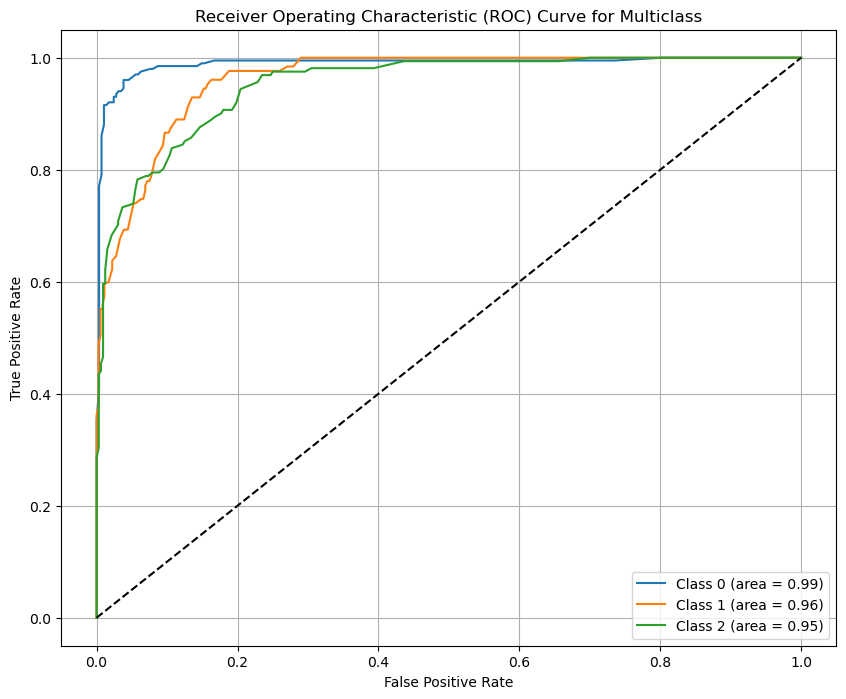

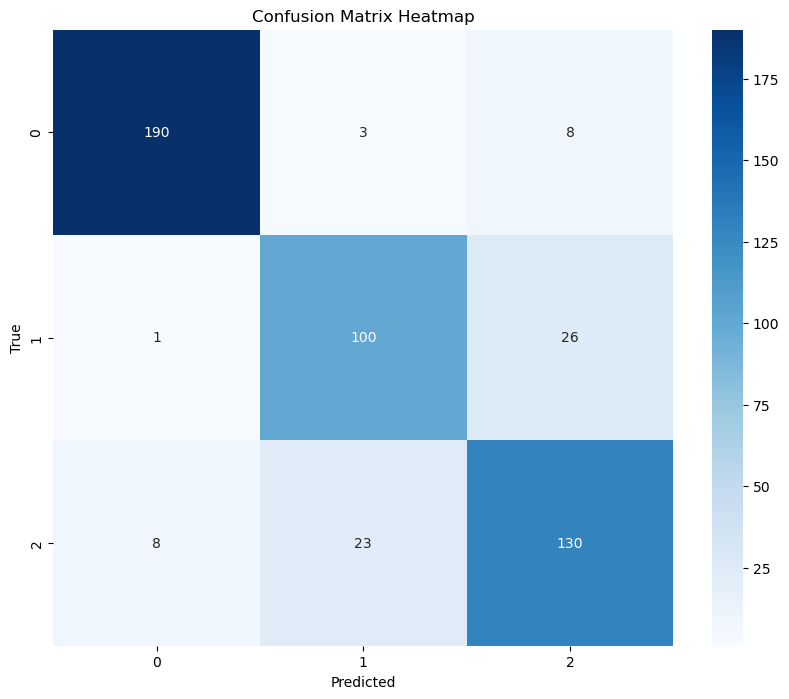

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Predict and evaluate
y_pred_pos = rf_pos_cat.predict(X_test_pos)
y_proba_pos = rf_pos_cat.predict_proba(X_test_pos)  # Probability estimates for all classes

# Print classification report
print("Classification Report for Pos_Cat Prediction:")
print(classification_report(y_test_pos, y_pred_pos, zero_division=1))

# Calculate confusion matrix
cm = confusion_matrix(y_test_pos, y_pred_pos)
print("Confusion Matrix:")
print(cm)

# Calculate additional metrics
accuracy = accuracy_score(y_test_pos, y_pred_pos)
precision = precision_score(y_test_pos, y_pred_pos, average='macro')  # Use 'micro', 'macro', or 'weighted' for multiclass
recall = recall_score(y_test_pos, y_pred_pos, average='macro')
f1 = f1_score(y_test_pos, y_pred_pos, average='macro')

# ROC AUC Score requires a binary or multilabel-indicator format
# For multiclass, compute AUC for each class and average them
try:
    roc_auc = roc_auc_score(y_test_pos, y_proba_pos, multi_class='ovr')
except ValueError:
    roc_auc = 'Cannot compute AUC for multiclass with the current settings.'

# Print additional metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro Average): {precision:.4f}")
print(f"Recall (Macro Average): {recall:.4f}")
print(f"F1 Score (Macro Average): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc}")

# Plot ROC Curve (one vs rest for multiclass)
n_classes = y_proba_pos.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_pos == i, y_proba_pos[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Optionally visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_pos), yticklabels=np.unique(y_test_pos))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


## Hyperparameter Tuning for RF

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.77      0.80      0.78       127
           2       0.80      0.76      0.78       161

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Confusion Matrix for Best Model:
[[192   2   7]
 [  2 101  24]
 [  9  29 123]]
Accuracy: 0.8507
Precision (Macro Average): 0.8366
Recall (Macro Average): 0.8382
F1 Score (Macro Average): 0.8371
ROC AUC Score: 0.9684743335793339


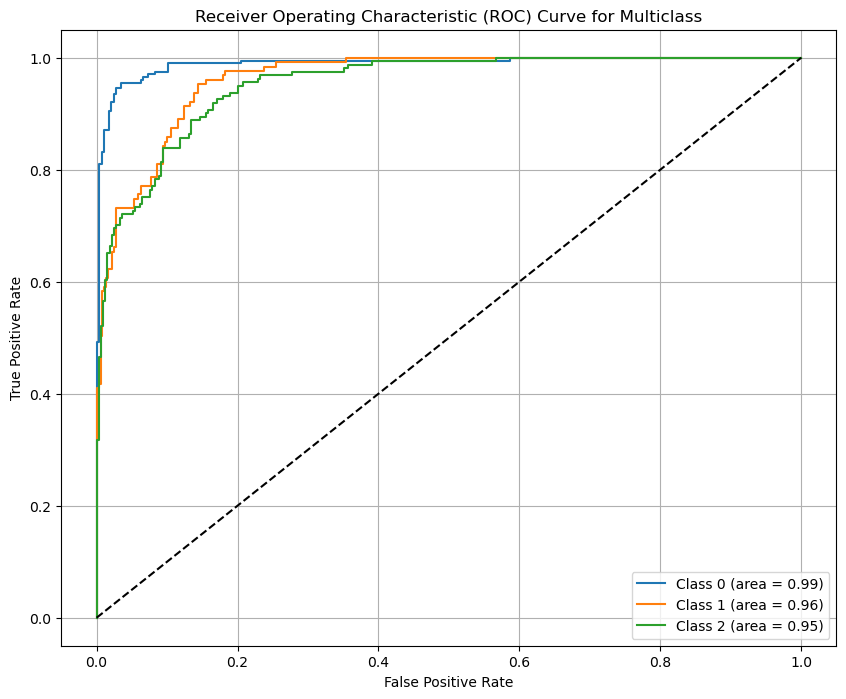

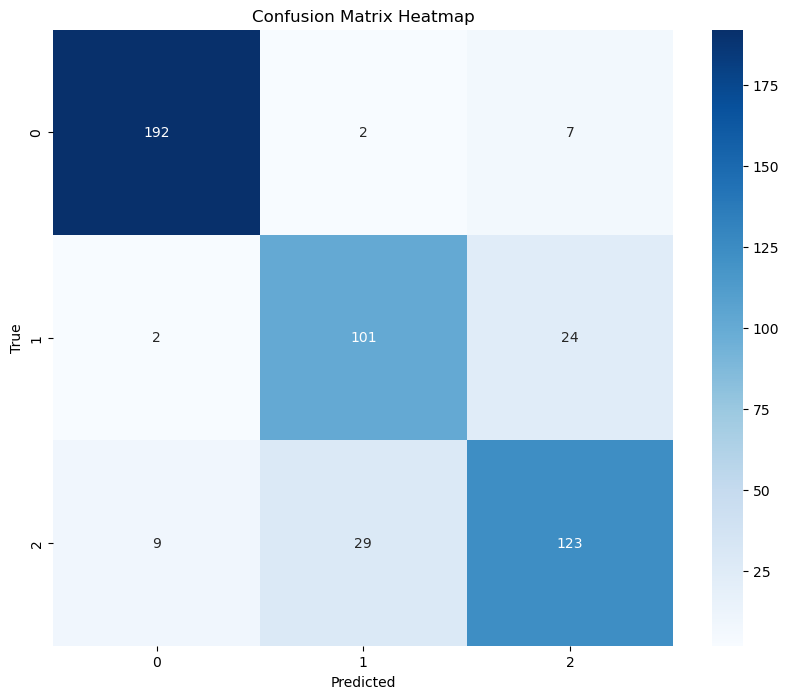

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_pos, y_train_pos)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_pos_cat = grid_search.best_estimator_

# Predict and evaluate the best model
y_pred_best = best_rf_pos_cat.predict(X_test_pos)
y_proba_best = best_rf_pos_cat.predict_proba(X_test_pos)  # Probability estimates for all classes

# Print classification report
print("Classification Report for Best Model:")
print(classification_report(y_test_pos, y_pred_best, zero_division=1))

# Calculate confusion matrix
cm_best = confusion_matrix(y_test_pos, y_pred_best)
print("Confusion Matrix for Best Model:")
print(cm_best)

# Calculate additional metrics
accuracy = accuracy_score(y_test_pos, y_pred_best)
precision = precision_score(y_test_pos, y_pred_best, average='macro')  # Use 'micro', 'macro', or 'weighted' for multiclass
recall = recall_score(y_test_pos, y_pred_best, average='macro')
f1 = f1_score(y_test_pos, y_pred_best, average='macro')

# ROC AUC Score requires a binary or multilabel-indicator format
# For multiclass, compute AUC for each class and average them
try:
    roc_auc = roc_auc_score(y_test_pos, y_proba_best, multi_class='ovr')
except ValueError:
    roc_auc = 'Cannot compute AUC for multiclass with the current settings.'

# Print additional metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro Average): {precision:.4f}")
print(f"Recall (Macro Average): {recall:.4f}")
print(f"F1 Score (Macro Average): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc}")

# Plot ROC Curve (one vs rest for multiclass)
n_classes = y_proba_best.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_pos == i, y_proba_best[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Optionally visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_pos), yticklabels=np.unique(y_test_pos))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


## Feature importance analysis

Total number of features used for training/testing: 99
Classification Report for Best Model with Top 99 Features:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       201
           1       0.79      0.80      0.79       127
           2       0.78      0.78      0.78       161

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Confusion Matrix for Best Model with Top 99 Features:
[[191   0  10]
 [  1 101  25]
 [  9  27 125]]


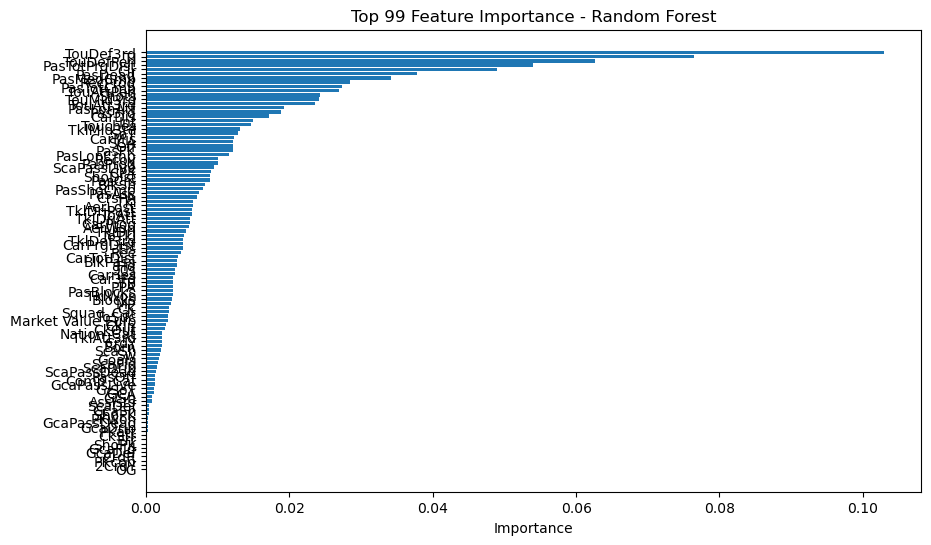

Total number of features used for training/testing: 98
Classification Report for Best Model with Top 98 Features:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       201
           1       0.77      0.81      0.79       127
           2       0.79      0.77      0.78       161

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.86      0.85      0.86       489

Confusion Matrix for Best Model with Top 98 Features:
[[191   2   8]
 [  0 103  24]
 [  8  29 124]]


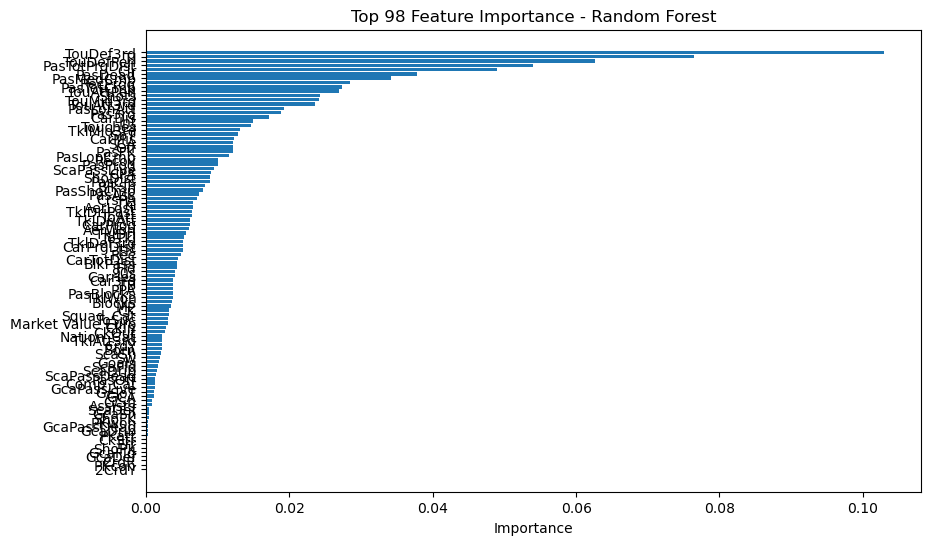

Performance change is less than the tolerance (0.01), continuing to test lower feature counts...

Performance Metrics Across Feature Reductions:
    feature_count  accuracy        f1  precision    recall   roc_auc
0              99  0.852761  0.840407   0.840187  0.840641  0.969715
1              98  0.854806  0.842202   0.841109  0.843820  0.968591
2              97  0.854806  0.841616   0.841029  0.842299  0.968494
3              96  0.844581  0.831139   0.830338  0.832217  0.967629
4              95  0.852761  0.840439   0.839273  0.842715  0.969382
5              94  0.854806  0.841959   0.841066  0.843265  0.968435
6              93  0.850716  0.837696   0.836784  0.838982  0.969212
7              92  0.846626  0.833321   0.833321  0.833321  0.969495
8              91  0.850716  0.837919   0.837426  0.838570  0.968675
9              90  0.854806  0.842606   0.841477  0.844232  0.968705
10             89  0.848671  0.834883   0.834388  0.835534  0.969941
11             88  0.848671

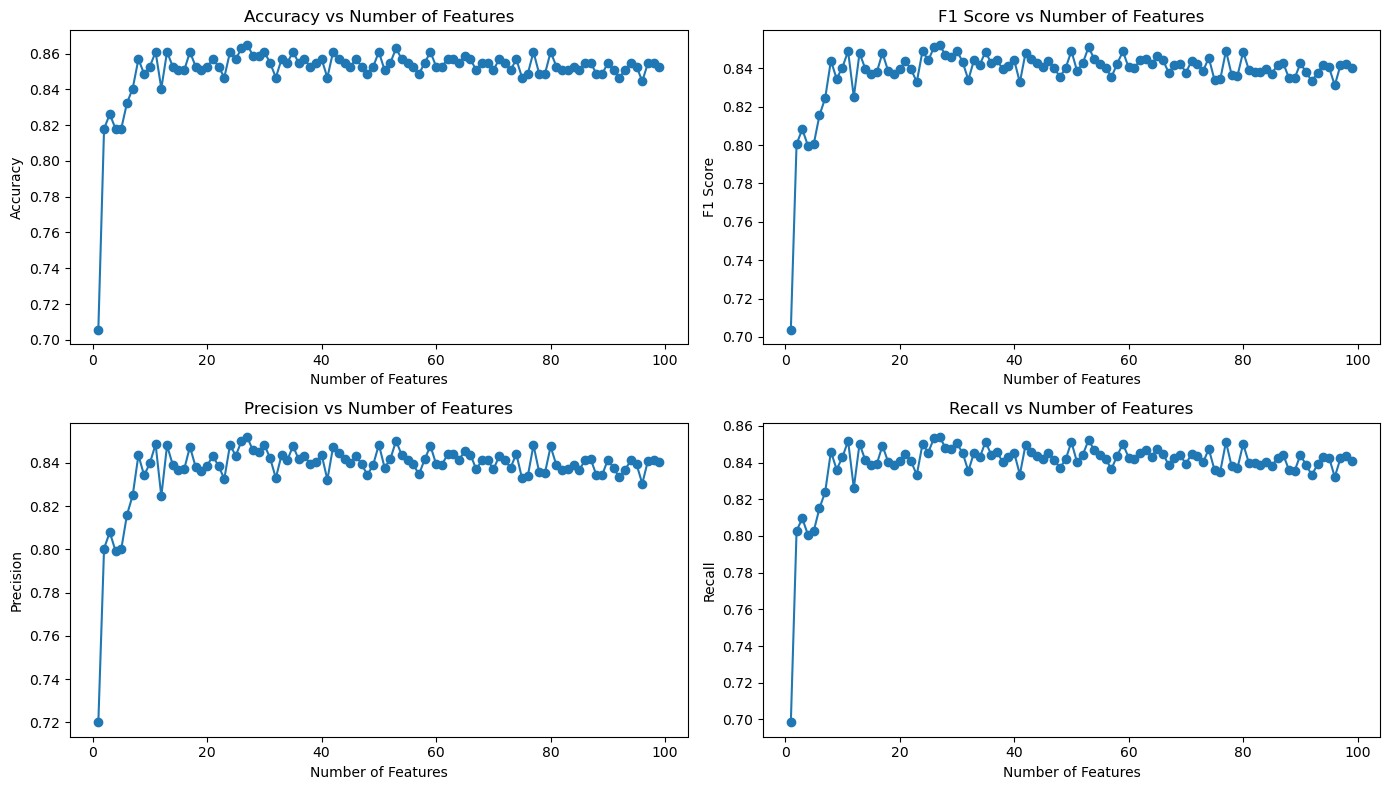

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define the best parameters
best_params = {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

# Train the RandomForestClassifier with the best parameters
best_rf_pos_cat = RandomForestClassifier(**best_params, random_state=42)
best_rf_pos_cat.fit(X_train_pos, y_train_pos)

# Extract feature importances
importances = best_rf_pos_cat.feature_importances_
feature_names = X_train_pos.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Initialize variables for iteration
previous_performance = None
tolerance = 0.01  # Threshold for change in performance to stop iteration
min_features = 1  # Minimum number of features to use

# Initialize a dictionary to store performance metrics
performance_metrics = {
    'feature_count': [],
    'accuracy': [],
    'f1': [],
    'precision': [],
    'recall': [],
    'roc_auc': []
}

# Prepare the binary format for ROC AUC
y_test_binarized = label_binarize(y_test_pos, classes=np.unique(y_train_pos))

# Loop to reduce features
for n in range(len(feature_names), min_features - 1, -1):
    # Select top n features
    top_n_features = feature_importances.head(n)['Feature'].values

    # Filter the training and test sets to include only the top n features
    X_train_top_n = X_train_pos[top_n_features]
    X_test_top_n = X_test_pos[top_n_features]

    # Train the RandomForestClassifier on the top n features
    best_rf_pos_cat_top_n = RandomForestClassifier(**best_params, random_state=42)
    best_rf_pos_cat_top_n.fit(X_train_top_n, y_train_pos)

    # Predict on the test set with top n features
    y_pred_best_top_n = best_rf_pos_cat_top_n.predict(X_test_top_n)
    y_pred_prob_best_top_n = best_rf_pos_cat_top_n.predict_proba(X_test_top_n)

    # Calculate performance metrics
    current_accuracy = accuracy_score(y_test_pos, y_pred_best_top_n)
    current_f1 = f1_score(y_test_pos, y_pred_best_top_n, average='macro')
    current_precision = precision_score(y_test_pos, y_pred_best_top_n, average='macro')
    current_recall = recall_score(y_test_pos, y_pred_best_top_n, average='macro')

    # Compute ROC AUC
    current_roc_auc = roc_auc_score(y_test_binarized, y_pred_prob_best_top_n, average='macro', multi_class='ovo')

    # Store performance metrics
    performance_metrics['feature_count'].append(n)
    performance_metrics['accuracy'].append(current_accuracy)
    performance_metrics['f1'].append(current_f1)
    performance_metrics['precision'].append(current_precision)
    performance_metrics['recall'].append(current_recall)
    performance_metrics['roc_auc'].append(current_roc_auc)

    # Print classification report and confusion matrix
    print(f'Total number of features used for training/testing: {n}')
    print(f"Classification Report for Best Model with Top {n} Features:")
    print(classification_report(y_test_pos, y_pred_best_top_n, zero_division=1))
    cm_best_top_n = confusion_matrix(y_test_pos, y_pred_best_top_n)
    print(f"Confusion Matrix for Best Model with Top {n} Features:")
    print(cm_best_top_n)

    # Plot the top n features
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_features, feature_importances[feature_importances['Feature'].isin(top_n_features)]['Importance'], align='center')
    plt.xlabel('Importance')
    plt.title(f'Top {n} Feature Importance - Random Forest')
    plt.gca().invert_yaxis()
    plt.show()

    # Check if performance improvement is less than the tolerance
    if previous_performance is not None:
        if (abs(current_accuracy - previous_performance['accuracy']) < tolerance and
            abs(current_f1 - previous_performance['f1']) < tolerance and
            abs(current_precision - previous_performance['precision']) < tolerance and
            abs(current_recall - previous_performance['recall']) < tolerance and
            abs(current_roc_auc - previous_performance['roc_auc']) < tolerance):
            # Test additional features beyond the stopping point
            print(f"Performance change is less than the tolerance ({tolerance}), continuing to test lower feature counts...")
            # Test features below the current stopping point
            for test_n in range(n - 1, min_features - 1, -1):
                top_test_features = feature_importances.head(test_n)['Feature'].values
                X_train_test = X_train_pos[top_test_features]
                X_test_test = X_test_pos[top_test_features]
                model = RandomForestClassifier(**best_params, random_state=42)
                model.fit(X_train_test, y_train_pos)
                y_pred_test = model.predict(X_test_test)
                y_pred_prob_test = model.predict_proba(X_test_test)
                accuracy_test = accuracy_score(y_test_pos, y_pred_test)
                f1_test = f1_score(y_test_pos, y_pred_test, average='macro')
                precision_test = precision_score(y_test_pos, y_pred_test, average='macro')
                recall_test = recall_score(y_test_pos, y_pred_test, average='macro')
                roc_auc_test = roc_auc_score(y_test_binarized, y_pred_prob_test, average='macro', multi_class='ovo')
                performance_metrics['feature_count'].append(test_n)
                performance_metrics['accuracy'].append(accuracy_test)
                performance_metrics['f1'].append(f1_test)
                performance_metrics['precision'].append(precision_test)
                performance_metrics['recall'].append(recall_test)
                performance_metrics['roc_auc'].append(roc_auc_test)
            break

    # Update previous performance metrics
    previous_performance = {
        'accuracy': current_accuracy,
        'f1': current_f1,
        'precision': current_precision,
        'recall': current_recall,
        'roc_auc': current_roc_auc
    }

# Convert performance metrics to DataFrame for easier analysis
performance_df = pd.DataFrame(performance_metrics)
print("\nPerformance Metrics Across Feature Reductions:")
print(performance_df)

# Plot the performance metrics
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(performance_df['feature_count'], performance_df['accuracy'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')

plt.subplot(2, 2, 2)
plt.plot(performance_df['feature_count'], performance_df['f1'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Features')

plt.subplot(2, 2, 3)
plt.plot(performance_df['feature_count'], performance_df['precision'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Precision')
plt.title('Precision vs Number of Features')

plt.subplot(2, 2, 4)
plt.plot(performance_df['feature_count'], performance_df['recall'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.title('Recall vs Number of Features')

plt.tight_layout()
plt.show()


Total number of features in the original dataset: 99
Total number of features used for training/testing: 13
Classification Report for Best Model with Top N Features (Top 13 Features):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.76      0.83      0.79       127
           2       0.84      0.76      0.80       161

    accuracy                           0.86       489
   macro avg       0.85      0.85      0.85       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best Model with Top N Features (Top 13 Features):
[[193   5   3]
 [  2 105  20]
 [  9  29 123]]
ROC AUC Score: 0.9661
F1 Score: 0.8606


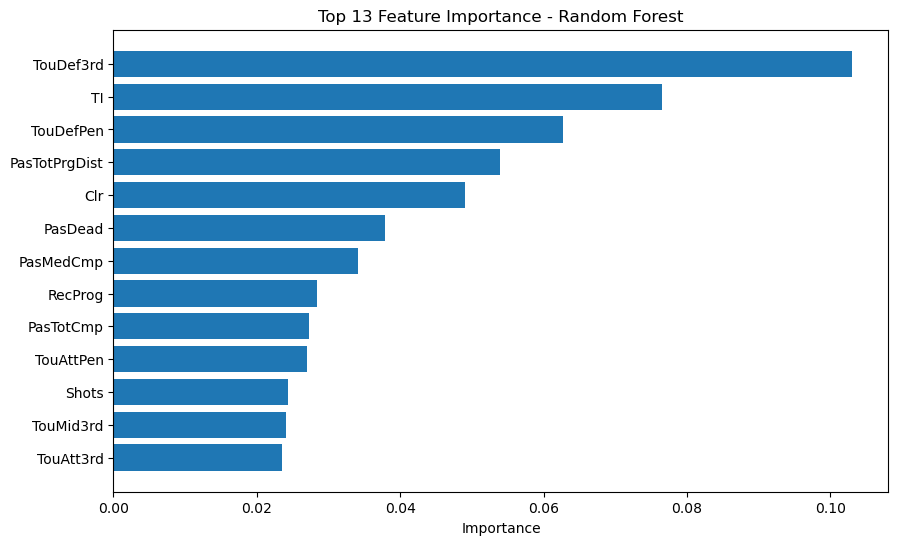

In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt

# Define the best parameters
best_params = {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

# Train the RandomForestClassifier with the best parameters
best_rf_pos_cat = RandomForestClassifier(**best_params, random_state=42)
best_rf_pos_cat.fit(X_train_pos, y_train_pos)

# Extract feature importances
importances = best_rf_pos_cat.feature_importances_
feature_names = X_train_pos.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display total number of features
total_features = X_train_pos.shape[1]
print(f'Total number of features in the original dataset: {total_features}')

# Display top 13 features
n = 13  # Number of top features to consider
top_n_features = feature_importances.head(n)['Feature'].values

# Display the number of features used after filtering
print(f'Total number of features used for training/testing: {len(top_n_features)}')

# Filter the training and test sets to include only the top n features
X_train_top_n = X_train_pos[top_n_features]
X_test_top_n = X_test_pos[top_n_features]

# Train the RandomForestClassifier on the top n features
best_rf_pos_cat_top_n = RandomForestClassifier(**best_params, random_state=42)
best_rf_pos_cat_top_n.fit(X_train_top_n, y_train_pos)

# Predict on the test set with top n features
y_pred_best_top_n = best_rf_pos_cat_top_n.predict(X_test_top_n)
y_prob_best_top_n = best_rf_pos_cat_top_n.predict_proba(X_test_top_n)[:, 1]  # Probabilities for ROC AUC

# Print classification report
print("Classification Report for Best Model with Top N Features (Top 13 Features):")
print(classification_report(y_test_pos, y_pred_best_top_n))

# Calculate confusion matrix
cm_best_top_n = confusion_matrix(y_test_pos, y_pred_best_top_n)
print("Confusion Matrix for Best Model with Top N Features (Top 13 Features):")
print(cm_best_top_n)

# Calculate additional performance metrics
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_n)
    print(f'ROC AUC Score: {roc_auc:.4f}')
else:  # Multi-class classification
    roc_auc = roc_auc_score(y_test_pos, best_rf_pos_cat_top_n.predict_proba(X_test_top_n), multi_class='ovr')
    print(f'ROC AUC Score: {roc_auc:.4f}')

f1 = f1_score(y_test_pos, y_pred_best_top_n, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Plot the top n features
plt.figure(figsize=(10, 6))
plt.barh(top_n_features, feature_importances[feature_importances['Feature'].isin(top_n_features)]['Importance'], align='center')
plt.xlabel('Importance')
plt.title(f'Top {len(top_n_features)} Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.show()


# Other models and best parameters

## Logistic regression

In [40]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the Logistic Regression model
lr_model = LogisticRegression(max_iter=50, random_state=42)
lr_model.fit(X_train_pos, y_train_pos)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_pos)
y_prob_lr = lr_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC

# Calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_lr)
f1 = f1_score(y_test_pos, y_pred_lr, average='weighted')
precision = precision_score(y_test_pos, y_pred_lr, average='weighted')
recall = recall_score(y_test_pos, y_pred_lr, average='weighted')

# Binarize the output for ROC AUC (for multi-class, ROC AUC is calculated as a one-vs-rest approach)
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_lr)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, lr_model.predict_proba(X_test_pos), multi_class='ovr')

# Print performance metrics
print("Logistic Regression Classification Report:")
print(classification_report(y_test_pos, y_pred_lr))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_lr))
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       201
           1       0.74      0.85      0.79       127
           2       0.83      0.76      0.79       161

    accuracy                           0.85       489
   macro avg       0.84      0.85      0.84       489
weighted avg       0.86      0.85      0.86       489

Logistic Regression Confusion Matrix:
[[188   6   7]
 [  1 108  18]
 [  7  32 122]]
Accuracy: 0.8548
F1 Score: 0.8556
Precision: 0.8596
Recall: 0.8548
ROC AUC Score: 0.9511


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Define the parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization parameter
    'solver': ['liblinear', 'lbfgs'],  # Optimization algorithms
    'penalty': ['l1', 'l2']  # Regularization type
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=100, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_pos, y_train_pos)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Use the best estimator to make predictions
best_lr_model = grid_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_pos)
y_prob_lr = best_lr_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_lr)
f1 = f1_score(y_test_pos, y_pred_lr, average='weighted')
precision = precision_score(y_test_pos, y_pred_lr, average='weighted')
recall = recall_score(y_test_pos, y_pred_lr, average='weighted')

# Binarize the output for ROC AUC (for multi-class, ROC AUC is calculated as a one-vs-rest approach)
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_lr)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_lr_model.predict_proba(X_test_pos), multi_class='ovr')

# Print classification report
print("Classification Report for Best Logistic Regression Model:")
print(classification_report(y_test_pos, y_pred_lr))

# Print confusion matrix
print("Confusion Matrix for Best Logistic Regression Model:")
print(confusion_matrix(y_test_pos, y_pred_lr))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\firda\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\firda\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\firda\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solver 

Best Parameters Found:
{'C': 1.623776739188721, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8766
Classification Report for Best Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       201
           1       0.76      0.83      0.80       127
           2       0.85      0.80      0.83       161

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.88      0.87      0.87       489

Confusion Matrix for Best Logistic Regression Model:
[[192   7   2]
 [  1 106  20]
 [  6  26 129]]
Accuracy: 0.8732
F1 Score: 0.8739
Precision: 0.8759
Recall: 0.8732
ROC AUC Score: 0.9552


In [42]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the top 13 features
top_n_features = [
    'TouDef3rd',
    'TI',
    'Clr',
    'PasTotPrgDist',
    'PasDead',
    'TouDefPen',
    'PasMedCmp',
    'TouAtt3rd',
    'RecProg',
    'TouAttPen',
    'PasTotCmp',
    'TouMid3rd',
    'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for Logistic Regression
best_lr_params = {'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear', 'random_state': 42}

# Train the Logistic Regression with the best parameters
best_lr_pos_cat_top_13 = LogisticRegression(**best_lr_params)
best_lr_pos_cat_top_13.fit(X_train_top_13, y_train_pos)

# Predict on the test set with top 13 features
y_pred_best_top_13 = best_lr_pos_cat_top_13.predict(X_test_top_13)
y_prob_best_top_13 = best_lr_pos_cat_top_13.predict_proba(X_test_top_13)[:, 1]  # Probabilities for ROC AUC

# Calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_13)
f1 = f1_score(y_test_pos, y_pred_best_top_13, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_13, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_13, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_13)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_lr_pos_cat_top_13.predict_proba(X_test_top_13), multi_class='ovr')

# Print classification report
print("Classification Report for Best Logistic Regression Model with Top 13 Features:")
print(classification_report(y_test_pos, y_pred_best_top_13))

# Print confusion matrix
print("Confusion Matrix for Best Logistic Regression Model with Top 13 Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_13))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report for Best Logistic Regression Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       201
           1       0.74      0.85      0.79       127
           2       0.82      0.69      0.75       161

    accuracy                           0.84       489
   macro avg       0.83      0.83      0.83       489
weighted avg       0.84      0.84      0.84       489

Confusion Matrix for Best Logistic Regression Model with Top 13 Features:
[[192   3   6]
 [  1 108  18]
 [ 15  35 111]]
Accuracy: 0.8405
F1 Score: 0.8383
Precision: 0.8423
Recall: 0.8405
ROC AUC Score: 0.9414


## KNN

In [43]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Initialize the K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn_model.fit(X_train_pos, y_train_pos)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test_pos)
y_prob_knn = knn_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_knn)
f1 = f1_score(y_test_pos, y_pred_knn, average='weighted')
precision = precision_score(y_test_pos, y_pred_knn, average='weighted')
recall = recall_score(y_test_pos, y_pred_knn, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_knn)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, knn_model.predict_proba(X_test_pos), multi_class='ovr')

# Print classification report
print("KNN Classification Report:")
print(classification_report(y_test_pos, y_pred_knn))

# Print confusion matrix
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_knn))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       201
           1       0.69      0.61      0.64       127
           2       0.59      0.53      0.56       161

    accuracy                           0.69       489
   macro avg       0.67      0.67      0.67       489
weighted avg       0.68      0.69      0.68       489

KNN Confusion Matrix:
[[172   4  25]
 [ 14  77  36]
 [ 44  31  86]]
Accuracy: 0.6851
F1 Score: 0.6793
Precision: 0.6786
Recall: 0.6851
ROC AUC Score: 0.8507


In [44]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 21)),  # Number of neighbors to test
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for the Minkowski distance metric (1 for Manhattan, 2 for Euclidean)
}

# Initialize the K-Nearest Neighbors model
knn_model = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_pos, y_train_pos)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Use the best estimator to make predictions
best_knn_model = grid_search.best_estimator_
y_pred_knn = best_knn_model.predict(X_test_pos)
y_prob_knn = best_knn_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_knn)
f1 = f1_score(y_test_pos, y_pred_knn, average='weighted')
precision = precision_score(y_test_pos, y_pred_knn, average='weighted')
recall = recall_score(y_test_pos, y_pred_knn, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_knn)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_knn_model.predict_proba(X_test_pos), multi_class='ovr')

# Print classification report
print("Classification Report for Best KNN Model:")
print(classification_report(y_test_pos, y_pred_knn))

# Print confusion matrix
print("Confusion Matrix for Best KNN Model:")
print(confusion_matrix(y_test_pos, y_pred_knn))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Best Parameters Found:
{'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.7982
Classification Report for Best KNN Model:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       201
           1       0.77      0.69      0.73       127
           2       0.75      0.67      0.71       161

    accuracy                           0.79       489
   macro avg       0.78      0.77      0.77       489
weighted avg       0.78      0.79      0.78       489

Confusion Matrix for Best KNN Model:
[[189   4   8]
 [ 11  88  28]
 [ 31  22 108]]
Accuracy: 0.7873
F1 Score: 0.7825
Precision: 0.7837
Recall: 0.7873
ROC AUC Score: 0.9315


In [45]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the top 13 features
top_n_features = [
    'TouDef3rd',
    'TI',
    'Clr',
    'PasTotPrgDist',
    'PasDead',
    'TouDefPen',
    'PasMedCmp',
    'TouAtt3rd',
    'RecProg',
    'TouAttPen',
    'PasTotCmp',
    'TouMid3rd',
    'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for KNN
best_knn_params = {'n_neighbors': 12, 'p': 1, 'weights': 'distance'}

# Train the KNN with the best parameters
best_knn_pos_cat_top_13 = KNeighborsClassifier(**best_knn_params)
best_knn_pos_cat_top_13.fit(X_train_top_13, y_train_pos)

# Predict on the test set with top 13 features
y_pred_best_top_13 = best_knn_pos_cat_top_13.predict(X_test_top_13)
y_prob_best_top_13 = best_knn_pos_cat_top_13.predict_proba(X_test_top_13)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_13)
f1 = f1_score(y_test_pos, y_pred_best_top_13, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_13, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_13, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_13)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_knn_pos_cat_top_13.predict_proba(X_test_top_13), multi_class='ovr')

# Print classification report
print("Classification Report for Best KNN Model with Top 13 Features:")
print(classification_report(y_test_pos, y_pred_best_top_13))

# Print confusion matrix
print("Confusion Matrix for Best KNN Model with Top 13 Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_13))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report for Best KNN Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       201
           1       0.78      0.83      0.80       127
           2       0.84      0.79      0.81       161

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

Confusion Matrix for Best KNN Model with Top 13 Features:
[[193   3   5]
 [  2 105  20]
 [  7  27 127]]
Accuracy: 0.8691
F1 Score: 0.8691
Precision: 0.8698
Recall: 0.8691
ROC AUC Score: 0.9571


## Gradient Boosting

In [46]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_pos, y_train_pos)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test_pos)
y_prob_gb = gb_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_gb)
f1 = f1_score(y_test_pos, y_pred_gb, average='weighted')
precision = precision_score(y_test_pos, y_pred_gb, average='weighted')
recall = recall_score(y_test_pos, y_pred_gb, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_gb)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, gb_model.predict_proba(X_test_pos), multi_class='ovr')

# Print classification report
print("Gradient Boosting Classification Report:")
print(classification_report(y_test_pos, y_pred_gb))

# Print confusion matrix
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_gb))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       201
           1       0.77      0.85      0.81       127
           2       0.86      0.78      0.82       161

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

Gradient Boosting Confusion Matrix:
[[192   6   3]
 [  1 108  18]
 [  8  27 126]]
Accuracy: 0.8712
F1 Score: 0.8713
Precision: 0.8738
Recall: 0.8712
ROC AUC Score: 0.9691


In [47]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinking to prevent overfitting
    'max_depth': [3, 5, 7],                # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]          # Minimum number of samples required to be at a leaf node
}

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_pos, y_train_pos)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Use the best estimator to make predictions
best_gb_model = grid_search.best_estimator_
y_pred_gb = best_gb_model.predict(X_test_pos)
y_prob_gb = best_gb_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Calculate performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_gb)
f1 = f1_score(y_test_pos, y_pred_gb, average='weighted')
precision = precision_score(y_test_pos, y_pred_gb, average='weighted')
recall = recall_score(y_test_pos, y_pred_gb, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_gb)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_gb_model.predict_proba(X_test_pos), multi_class='ovr')

# Print classification report
print("Classification Report for Best Gradient Boosting Model:")
print(classification_report(y_test_pos, y_pred_gb))

# Print confusion matrix
print("Confusion Matrix for Best Gradient Boosting Model:")
print(confusion_matrix(y_test_pos, y_pred_gb))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Best Parameters Found:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best Cross-Validation Accuracy: 0.8802
Classification Report for Best Gradient Boosting Model:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.77      0.83      0.80       127
           2       0.85      0.79      0.82       161

    accuracy                           0.87       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.87      0.87      0.87       489

Confusion Matrix for Best Gradient Boosting Model:
[[192   5   4]
 [  2 106  19]
 [  8  26 127]]
Accuracy: 0.8691
F1 Score: 0.8691
Precision: 0.8704
Recall: 0.8691
ROC AUC Score: 0.9691


In [48]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Define the top 13 features
top_13_features = [
    'TouDef3rd', 'TI', 'Clr', 'PasTotPrgDist', 'PasDead', 
    'TouDefPen', 'PasMedCmp', 'TouAtt3rd', 'RecProg', 'TouAttPen', 
    'PasTotCmp', 'TouMid3rd', 'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_13_features]
X_test_top_13 = X_test_pos[top_13_features]

# Define the best parameters for Gradient Boosting
best_gb_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 150,
    'random_state': 42
}

# Train the Gradient Boosting model with the best parameters
best_gb_pos_cat_top_13 = GradientBoostingClassifier(**best_gb_params)
best_gb_pos_cat_top_13.fit(X_train_top_13, y_train_pos)

# Predict on the test set with top 13 features
y_pred_best_top_13 = best_gb_pos_cat_top_13.predict(X_test_top_13)
y_prob_best_top_13 = best_gb_pos_cat_top_13.predict_proba(X_test_top_13)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Print classification report
print("Classification Report for Best Gradient Boosting Model with Top 13 Features:")
print(classification_report(y_test_pos, y_pred_best_top_13))

# Print confusion matrix
print("Confusion Matrix for Best Gradient Boosting Model with Top 13 Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_13))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_13)
f1 = f1_score(y_test_pos, y_pred_best_top_13, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_13, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_13, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_13)
    average_precision = average_precision_score(y_test_pos, y_prob_best_top_13)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_gb_pos_cat_top_13.predict_proba(X_test_top_13), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, best_gb_pos_cat_top_13.predict_proba(X_test_top_13))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


Classification Report for Best Gradient Boosting Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       201
           1       0.74      0.80      0.77       127
           2       0.79      0.75      0.77       161

    accuracy                           0.84       489
   macro avg       0.83      0.83      0.83       489
weighted avg       0.84      0.84      0.84       489

Confusion Matrix for Best Gradient Boosting Model with Top 13 Features:
[[190   3   8]
 [  3 101  23]
 [  9  32 120]]
Accuracy: 0.8405
F1 Score: 0.8403
Precision: 0.8412
Recall: 0.8405
ROC AUC Score: 0.9616
Average Precision Score: 0.9238


## Xtreme Gradient Boosting

In [49]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Train the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_pos, y_train_pos)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_pos)
y_prob_xgb = xgb_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Print classification report
print("XGBoost Classification Report:")
print(classification_report(y_test_pos, y_pred_xgb))

# Print confusion matrix
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_xgb))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_xgb)
f1 = f1_score(y_test_pos, y_pred_xgb, average='weighted')
precision = precision_score(y_test_pos, y_pred_xgb, average='weighted')
recall = recall_score(y_test_pos, y_pred_xgb, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_xgb)
    average_precision = average_precision_score(y_test_pos, y_prob_xgb)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, xgb_model.predict_proba(X_test_pos), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, xgb_model.predict_proba(X_test_pos))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       201
           1       0.76      0.80      0.78       127
           2       0.83      0.77      0.80       161

    accuracy                           0.86       489
   macro avg       0.84      0.85      0.84       489
weighted avg       0.86      0.86      0.86       489

XGBoost Confusion Matrix:
[[195   4   2]
 [  2 101  24]
 [  9  28 124]]
Accuracy: 0.8589
F1 Score: 0.8582
Precision: 0.8585
Recall: 0.8589
ROC AUC Score: 0.9683
Average Precision Score: 0.9343


In [50]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],    # Step size shrinking to prevent overfitting
    'max_depth': [3, 5, 7],               # Maximum depth of the individual trees
    'min_child_weight': [1, 3, 5],        # Minimum sum of instance weight (hessian) needed in a child
    'gamma': [0, 0.1, 0.3],               # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': [0.8, 1.0],              # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0]        # Subsample ratio of columns when constructing each tree
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_pos, y_train_pos)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Use the best estimator to make predictions
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_pos)
y_prob_xgb = best_xgb_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Print classification report
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_test_pos, y_pred_xgb))

# Print confusion matrix
print("Confusion Matrix for Best XGBoost Model:")
print(confusion_matrix(y_test_pos, y_pred_xgb))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_xgb)
f1 = f1_score(y_test_pos, y_pred_xgb, average='weighted')
precision = precision_score(y_test_pos, y_pred_xgb, average='weighted')
recall = recall_score(y_test_pos, y_pred_xgb, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_xgb)
    average_precision = average_precision_score(y_test_pos, y_prob_xgb)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_xgb_model.predict_proba(X_test_pos), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, best_xgb_model.predict_proba(X_test_pos))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


Best Parameters Found:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8833
Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.75      0.83      0.79       127
           2       0.86      0.77      0.81       161

    accuracy                           0.87       489
   macro avg       0.85      0.86      0.85       489
weighted avg       0.87      0.87      0.86       489

Confusion Matrix for Best XGBoost Model:
[[193   6   2]
 [  3 106  18]
 [  8  29 124]]
Accuracy: 0.8650
F1 Score: 0.8649
Precision: 0.8676
Recall: 0.8650
ROC AUC Score: 0.9707
Average Precision Score: 0.9401


In [51]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Define the top 13 features
top_n_features = [
    'TouDef3rd',
    'TI',
    'Clr',
    'PasTotPrgDist',
    'PasDead',
    'TouDefPen',
    'PasMedCmp',
    'TouAtt3rd',
    'RecProg',
    'TouAttPen',
    'PasTotCmp',
    'TouMid3rd',
    'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for XGBoost
best_xgb_params = {
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'learning_rate': 0.2,
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 50,
    'subsample': 0.8
}

# Train the XGBoost model with the best parameters
best_xgb_pos_cat_top_13 = XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss')
best_xgb_pos_cat_top_13.fit(X_train_top_13, y_train_pos)

# Predict on the test set with top 13 features
y_pred_best_top_13 = best_xgb_pos_cat_top_13.predict(X_test_top_13)
y_prob_best_top_13 = best_xgb_pos_cat_top_13.predict_proba(X_test_top_13)[:, 1]  # Probabilities for ROC AUC (binary classification)

# Print classification report
print("Classification Report for Best XGBoost Model with Top 13 Features:")
print(classification_report(y_test_pos, y_pred_best_top_13))

# Print confusion matrix
print("Confusion Matrix for Best XGBoost Model with Top 13 Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_13))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_13)
f1 = f1_score(y_test_pos, y_pred_best_top_13, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_13, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_13, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_13)
    average_precision = average_precision_score(y_test_pos, y_prob_best_top_13)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, best_xgb_pos_cat_top_13.predict_proba(X_test_top_13), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, best_xgb_pos_cat_top_13.predict_proba(X_test_top_13))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


Classification Report for Best XGBoost Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       201
           1       0.75      0.83      0.79       127
           2       0.84      0.73      0.78       161

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Confusion Matrix for Best XGBoost Model with Top 13 Features:
[[193   3   5]
 [  3 106  18]
 [ 11  32 118]]
Accuracy: 0.8528
F1 Score: 0.8516
Precision: 0.8540
Recall: 0.8528
ROC AUC Score: 0.9643
Average Precision Score: 0.9281


## Neural Network

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Neural Network
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train_pos, y_train_pos)
y_pred_mlp = mlp_model.predict(X_test_pos)
y_prob_mlp = mlp_model.predict_proba(X_test_pos)[:, 1]  # Probabilities for ROC AUC (binary classification)

print("Neural Network (MLP) Classification Report:")
print(classification_report(y_test_pos, y_pred_mlp))

print("Neural Network (MLP) Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_mlp))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_mlp)
f1 = f1_score(y_test_pos, y_pred_mlp, average='weighted')
precision = precision_score(y_test_pos, y_pred_mlp, average='weighted')
recall = recall_score(y_test_pos, y_pred_mlp, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_mlp)
    average_precision = average_precision_score(y_test_pos, y_prob_mlp)
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, mlp_model.predict_proba(X_test_pos), multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, mlp_model.predict_proba(X_test_pos))

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


Neural Network (MLP) Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       201
           1       0.78      0.74      0.76       127
           2       0.78      0.84      0.81       161

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.86      0.85      0.85       489

Neural Network (MLP) Confusion Matrix:
[[188   4   9]
 [  3  94  30]
 [  3  23 135]]
Accuracy: 0.8528
F1 Score: 0.8535
Precision: 0.8555
Recall: 0.8528
ROC AUC Score: 0.9374
Average Precision Score: 0.8546


In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Define the parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50)],  # Different layer sizes
    'activation': ['tanh', 'relu'],  # Activation functions
    'solver': ['sgd', 'adam'],  # Solvers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization term
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'max_iter': [200, 500, 1000]  # Number of iterations
}

# Initialize the MLPClassifier
mlp_model = MLPClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_pos, y_train_pos)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Use the best estimator to make predictions
best_mlp_model = grid_search.best_estimator_
y_pred_mlp = best_mlp_model.predict(X_test_pos)
y_prob_mlp = best_mlp_model.predict_proba(X_test_pos)  # Probabilities for ROC AUC (binary classification)

print("Classification Report for Best MLP Model:")
print(classification_report(y_test_pos, y_pred_mlp))

print("Confusion Matrix for Best MLP Model:")
print(confusion_matrix(y_test_pos, y_pred_mlp))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_mlp)
f1 = f1_score(y_test_pos, y_pred_mlp, average='weighted')
precision = precision_score(y_test_pos, y_pred_mlp, average='weighted')
recall = recall_score(y_test_pos, y_pred_mlp, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_mlp[:, 1])
    average_precision = average_precision_score(y_test_pos, y_prob_mlp[:, 1])
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, y_prob_mlp, multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, y_prob_mlp)

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


C:\Users\firda\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters Found:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 0.8786
Classification Report for Best MLP Model:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       201
           1       0.75      0.80      0.77       127
           2       0.82      0.80      0.81       161

    accuracy                           0.86       489
   macro avg       0.84      0.85      0.84       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best MLP Model:
[[190   6   5]
 [  2 101  24]
 [  6  27 128]]
Accuracy: 0.8569
F1 Score: 0.8575
Precision: 0.8586
Recall: 0.8569
ROC AUC Score: 0.9628
Average Precision Score: 0.9197


In [54]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Assuming top_n_features contains the top 13 features
# For example: top_n_features = ['TouDef3rd', 'TouDefPen', ..., 'AerLost']

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for MLP
best_mlp_params = {
    'activation': 'relu',
    'alpha': 0.01,
    'hidden_layer_sizes': (100,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
    'solver': 'sgd'
}

# Train the MLP model with the best parameters
best_mlp_pos_cat_top_13 = MLPClassifier(**best_mlp_params)
best_mlp_pos_cat_top_13.fit(X_train_top_13, y_train_pos)

# Predict on the test set with top 13 features
y_pred_best_top_13 = best_mlp_pos_cat_top_13.predict(X_test_top_13)
y_prob_best_top_13 = best_mlp_pos_cat_top_13.predict_proba(X_test_top_13)  # Probabilities for ROC AUC (binary classification)

# Print classification report
print("Classification Report for Best MLP Model with Top 13 Features:")
print(classification_report(y_test_pos, y_pred_best_top_13))

# Print confusion matrix
print("Confusion Matrix for Best MLP Model with Top 13 Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_13))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_13)
f1 = f1_score(y_test_pos, y_pred_best_top_13, average='weighted')
precision = precision_score(y_test_pos, y_pred_best_top_13, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_13, average='weighted')

# Calculate ROC AUC score
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_13[:, 1])
    average_precision = average_precision_score(y_test_pos, y_prob_best_top_13[:, 1])
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=list(set(y_train_pos)))
    roc_auc = roc_auc_score(y_test_binarized, y_prob_best_top_13, multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, y_prob_best_top_13)

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Average Precision Score: {average_precision:.4f}")


Classification Report for Best MLP Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       201
           1       0.74      0.84      0.79       127
           2       0.83      0.76      0.79       161

    accuracy                           0.86       489
   macro avg       0.84      0.85      0.84       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best MLP Model with Top 13 Features:
[[190   5   6]
 [  1 107  19]
 [  7  32 122]]
Accuracy: 0.8569
F1 Score: 0.8574
Precision: 0.8607
Recall: 0.8569
ROC AUC Score: 0.9518
Average Precision Score: 0.8746


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


## Naive Bayes

In [55]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Naive Bayes Model Training
nb_model = GaussianNB()
nb_model.fit(X_train_pos, y_train_pos)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test_pos)
y_prob_nb = nb_model.predict_proba(X_test_pos)  # Probabilities for ROC AUC

# Print classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test_pos, y_pred_nb))

# Print confusion matrix
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test_pos, y_pred_nb))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_nb)
precision = precision_score(y_test_pos, y_pred_nb, average='weighted')
recall = recall_score(y_test_pos, y_pred_nb, average='weighted')
f1 = f1_score(y_test_pos, y_pred_nb, average='weighted')

# Calculate ROC AUC and Average Precision (for binary classification)
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_nb[:, 1])
    average_precision = average_precision_score(y_test_pos, y_prob_nb[:, 1])
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=np.unique(y_train_pos))
    roc_auc = roc_auc_score(y_test_binarized, y_prob_nb, multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, y_prob_nb, average='macro')

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Print ROC AUC and Average Precision
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       201
           1       0.69      0.87      0.77       127
           2       0.69      0.33      0.45       161

    accuracy                           0.71       489
   macro avg       0.70      0.70      0.67       489
weighted avg       0.70      0.71      0.68       489

Naive Bayes Confusion Matrix:
[[181   7  13]
 [  5 111  11]
 [ 66  42  53]]
Accuracy: 0.7055
Precision (weighted): 0.7020
Recall (weighted): 0.7055
F1 Score (weighted): 0.6760
ROC AUC: 0.8823
Average Precision: 0.7634


In [56]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Define the parameter grid for GaussianNB
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Variance smoothing values
}

# Initialize the GaussianNB
nb_model = GaussianNB()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_pos, y_train_pos)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters Found:")
print(best_params)
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Use the best estimator to make predictions
best_nb_model = grid_search.best_estimator_
y_pred_nb = best_nb_model.predict(X_test_pos)
y_prob_nb = best_nb_model.predict_proba(X_test_pos)  # Probabilities for ROC AUC and Average Precision

# Print classification report
print("Classification Report for Best Naive Bayes Model:")
print(classification_report(y_test_pos, y_pred_nb))

# Print confusion matrix
print("Confusion Matrix for Best Naive Bayes Model:")
print(confusion_matrix(y_test_pos, y_pred_nb))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_nb)
precision = precision_score(y_test_pos, y_pred_nb, average='weighted')
recall = recall_score(y_test_pos, y_pred_nb, average='weighted')
f1 = f1_score(y_test_pos, y_pred_nb, average='weighted')

# Calculate ROC AUC and Average Precision (for binary classification)
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_nb[:, 1])
    average_precision = average_precision_score(y_test_pos, y_prob_nb[:, 1])
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=np.unique(y_train_pos))
    roc_auc = roc_auc_score(y_test_binarized, y_prob_nb, multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, y_prob_nb, average='macro')

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Print ROC AUC and Average Precision
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")


Best Parameters Found:
{'var_smoothing': 1e-05}
Best Cross-Validation Accuracy: 0.6825
Classification Report for Best Naive Bayes Model:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       201
           1       0.70      0.87      0.78       127
           2       0.66      0.30      0.42       161

    accuracy                           0.71       489
   macro avg       0.69      0.70      0.67       489
weighted avg       0.70      0.71      0.67       489

Confusion Matrix for Best Naive Bayes Model:
[[185   5  11]
 [  2 111  14]
 [ 70  42  49]]
Accuracy: 0.7055
Precision (weighted): 0.6964
Recall (weighted): 0.7055
F1 Score (weighted): 0.6717
ROC AUC: 0.9013
Average Precision: 0.7947


In [57]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Define the top 13 features
top_n_features = [
    'TouDef3rd',
    'TI',
    'Clr',
    'PasTotPrgDist',
    'PasDead',
    'TouDefPen',
    'PasMedCmp',
    'TouAtt3rd',
    'RecProg',
    'TouAttPen',
    'PasTotCmp',
    'TouMid3rd',
    'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for Naive Bayes
best_nb_params = {'var_smoothing': 1e-05}

# Train the Naive Bayes model with the best parameters
best_nb_pos_cat_top_13 = GaussianNB(**best_nb_params)
best_nb_pos_cat_top_13.fit(X_train_top_13, y_train_pos)

# Predict on the test set with top 13 features
y_pred_best_top_13 = best_nb_pos_cat_top_13.predict(X_test_top_13)
y_prob_best_top_13 = best_nb_pos_cat_top_13.predict_proba(X_test_top_13)  # Probabilities for ROC AUC and Average Precision

# Print classification report
print("Classification Report for Best Naive Bayes Model with Top 13 Features:")
print(classification_report(y_test_pos, y_pred_best_top_13))

# Print confusion matrix
print("Confusion Matrix for Best Naive Bayes Model with Top 13 Features:")
print(confusion_matrix(y_test_pos, y_pred_best_top_13))

# Calculate additional performance metrics
accuracy = accuracy_score(y_test_pos, y_pred_best_top_13)
precision = precision_score(y_test_pos, y_pred_best_top_13, average='weighted')
recall = recall_score(y_test_pos, y_pred_best_top_13, average='weighted')
f1 = f1_score(y_test_pos, y_pred_best_top_13, average='weighted')

# Calculate ROC AUC and Average Precision (for binary classification)
if len(set(y_test_pos)) == 2:  # Binary classification
    roc_auc = roc_auc_score(y_test_pos, y_prob_best_top_13[:, 1])
    average_precision = average_precision_score(y_test_pos, y_prob_best_top_13[:, 1])
else:  # Multi-class classification
    y_test_binarized = label_binarize(y_test_pos, classes=np.unique(y_train_pos))
    roc_auc = roc_auc_score(y_test_binarized, y_prob_best_top_13, multi_class='ovr')
    average_precision = average_precision_score(y_test_binarized, y_prob_best_top_13, average='macro')

# Print additional performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Print ROC AUC and Average Precision
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")


Classification Report for Best Naive Bayes Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       201
           1       0.64      0.90      0.75       127
           2       0.82      0.53      0.64       161

    accuracy                           0.80       489
   macro avg       0.79      0.79      0.77       489
weighted avg       0.81      0.80      0.79       489

Confusion Matrix for Best Naive Bayes Model with Top 13 Features:
[[190   4   7]
 [  1 114  12]
 [ 15  61  85]]
Accuracy: 0.7955
Precision (weighted): 0.8136
Recall (weighted): 0.7955
F1 Score (weighted): 0.7885
ROC AUC: 0.9315
Average Precision: 0.8266


In [58]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Define the top 13 features
top_n_features = [
    'TouDef3rd', 'TI', 'Clr', 'PasTotPrgDist', 'PasDead',
    'TouDefPen', 'PasMedCmp', 'TouAtt3rd', 'RecProg',
    'TouAttPen', 'PasTotCmp', 'TouMid3rd', 'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for each model
best_params = {
    'RandomForest': {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200},
    'GradientBoosting': {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150},
    'XGBoost': {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8},
    'KNN': {'n_neighbors': 12, 'p': 1, 'weights': 'distance'},
    'LogisticRegression': {'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear'},
    'MLP': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'},
    'NaiveBayes': {'var_smoothing': 1e-05}
}

# Define the models
models = {
    'RandomForest': RandomForestClassifier(**best_params['RandomForest'], random_state=42),
    'GradientBoosting': GradientBoostingClassifier(**best_params['GradientBoosting'], random_state=42),
    'XGBoost': XGBClassifier(**best_params['XGBoost'], random_state=42),
    'KNN': KNeighborsClassifier(**best_params['KNN']),
    'LogisticRegression': LogisticRegression(**best_params['LogisticRegression'], random_state=42),
    'MLP': MLPClassifier(**best_params['MLP'], random_state=42),
    'NaiveBayes': GaussianNB(**best_params['NaiveBayes'])
}

# Define the number of splits for K-Fold
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"Running CV for {model_name}")
    
    # Fit the model on the entire training set
    model.fit(X_train_top_13, y_train_pos)
    
    # Predict on the test set
    y_pred = model.predict(X_test_top_13)
    
    # Check if the model supports predict_proba
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_top_13)
        
        # For binary classification, y_prob[:, 1] gives the probability for the positive class
        if y_prob.shape[1] == 2:
            y_prob = y_prob[:, 1]
        # For multi-class classification, y_prob remains 2D, and roc_auc_score needs proper handling
    else:
        y_prob = None
    
    # Print classification report
    print(f"Classification Report for Best {model_name} Model:")
    print(classification_report(y_test_pos, y_pred))
    
    # Print confusion matrix
    print(f"Confusion Matrix for Best {model_name} Model:")
    print(confusion_matrix(y_test_pos, y_pred))
    
    # Calculate and print additional performance metrics
    if y_prob is not None:
        # ROC AUC Score
        if len(np.unique(y_test_pos)) > 2:  # Check if it's multi-class
            roc_auc = roc_auc_score(y_test_pos, y_prob, average='macro', multi_class='ovr')
        else:
            roc_auc = roc_auc_score(y_test_pos, y_prob)
        print(f"ROC AUC Score for Best {model_name} Model: {roc_auc:.4f}")

        # Precision-Recall Curve (For binary classification)
        if y_prob.ndim == 1:
            precision, recall, _ = precision_recall_curve(y_test_pos, y_prob)
            pr_auc = auc(recall, precision)
            print(f"Precision-Recall AUC for Best {model_name} Model: {pr_auc:.4f}")

            # Plot Precision-Recall Curve
            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve for {model_name}')
            plt.grid(True)
            plt.show()

    print("\n")


Running CV for RandomForest
Classification Report for Best RandomForest Model:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.77      0.81      0.79       127
           2       0.81      0.76      0.79       161

    accuracy                           0.85       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.85      0.85      0.85       489

Confusion Matrix for Best RandomForest Model:
[[192   2   7]
 [  2 103  22]
 [  9  29 123]]
ROC AUC Score for Best RandomForest Model: 0.9665


Running CV for GradientBoosting
Classification Report for Best GradientBoosting Model:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       201
           1       0.74      0.80      0.77       127
           2       0.79      0.75      0.77       161

    accuracy                           0.84       489
   macro avg       0.83      0.83    

C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [59]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt

# Define the top 13 features
top_n_features = [
    'TouDef3rd', 'TI', 'Clr', 'PasTotPrgDist', 'PasDead',
    'TouDefPen', 'PasMedCmp', 'TouAtt3rd', 'RecProg',
    'TouAttPen', 'PasTotCmp', 'TouMid3rd', 'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for each model
best_params = {
    'RandomForest': {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200},
    'GradientBoosting': {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150},
    'XGBoost': {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8},
    'KNN': {'n_neighbors': 12, 'p': 1, 'weights': 'distance'},
    'LogisticRegression': {'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear'},
    'MLP': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'},
    'NaiveBayes': {'var_smoothing': 1e-05}
}

# Define the models
models = {
    'RandomForest': RandomForestClassifier(**best_params['RandomForest'], random_state=42),
    'GradientBoosting': GradientBoostingClassifier(**best_params['GradientBoosting'], random_state=42),
    'XGBoost': XGBClassifier(**best_params['XGBoost'], random_state=42),
    'KNN': KNeighborsClassifier(**best_params['KNN']),
    'LogisticRegression': LogisticRegression(**best_params['LogisticRegression'], random_state=42),
    'MLP': MLPClassifier(**best_params['MLP'], random_state=42),
    'NaiveBayes': GaussianNB(**best_params['NaiveBayes'])
}

# Define the parameter grid for each model
param_grids = {
    'RandomForest': {
        'max_depth': [10],
        'min_samples_leaf': [4],
        'min_samples_split': [2],
        'n_estimators': [200]
    },
    'GradientBoosting': {
        'learning_rate': [0.1],
        'max_depth': [7],
        'min_samples_leaf': [1],
        'min_samples_split': [5],
        'n_estimators': [150]
    },
    'XGBoost': {
        'colsample_bytree': [0.8],
        'gamma': [0.1],
        'learning_rate': [0.2],
        'max_depth': [5],
        'min_child_weight': [1],
        'n_estimators': [50],
        'subsample': [0.8]
    },
    'KNN': {
        'n_neighbors': [12],
        'p': [1],
        'weights': ['distance']
    },
    'LogisticRegression': {
        'C': [0.012742749857031334],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'MLP': {
        'activation': ['relu'],
        'alpha': [0.01],
        'hidden_layer_sizes': [(100,)],
        'learning_rate': ['adaptive'],
        'max_iter': [500],
        'solver': ['sgd']
    },
    'NaiveBayes': {
        'var_smoothing': [1e-05]
    }
}

# Configure the outer cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform nested cross-validation for each model
for model_name, model in models.items():
    print(f"Running Nested CV for {model_name}")
    outer_results = list()
    
    for train_ix, test_ix in cv_outer.split(X_train_top_13):
        X_train, X_test = X_train_top_13.iloc[train_ix, :], X_train_top_13.iloc[test_ix, :]
        y_train, y_test = y_train_pos.iloc[train_ix], y_train_pos.iloc[test_ix]
        
        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=42)
        
        # Define the search
        search = GridSearchCV(model, param_grids[model_name], scoring='accuracy', cv=cv_inner, refit=True)
        
        # Execute the search
        result = search.fit(X_train, y_train)
        
        # Get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # Evaluate the model on the hold-out dataset
        yhat = best_model.predict(X_test)
        
        # Evaluate the model
        acc = accuracy_score(y_test, yhat)
        
        # Store the result
        outer_results.append(acc)
        
        # Report progress
        print(f'>acc={acc:.3f}, est={result.best_score_:.3f}, cfg={result.best_params_}')
    
    # Summarize the estimated performance of the model
    print(f'Accuracy: {mean(outer_results):.3f} ({std(outer_results):.3f})')

    # Fit the best model on the entire training set
    search.fit(X_train_top_13, y_train_pos)
    best_model = search.best_estimator_
    
    # Predict on the test set with top 13 features
    y_pred = best_model.predict(X_test_top_13)
    
    # Print classification report
    print(f"Classification Report for Best {model_name} Model with Top 13 Features:")
    print(classification_report(y_test_pos, y_pred))
    
    # Print confusion matrix
    print(f"Confusion Matrix for Best {model_name} Model with Top 13 Features:")
    print(confusion_matrix(y_test_pos, y_pred))
    
    # Check if the model supports predict_proba
    if hasattr(best_model, 'predict_proba'):
        y_prob = best_model.predict_proba(X_test_top_13)
        
        # For binary classification, y_prob[:, 1] gives the probability for the positive class
        if y_prob.shape[1] == 2:
            y_prob = y_prob[:, 1]
        
        # ROC AUC Score
        if len(np.unique(y_test_pos)) > 2:  # Check if it's multi-class
            roc_auc = roc_auc_score(y_test_pos, y_prob, average='macro', multi_class='ovr')
        else:
            roc_auc = roc_auc_score(y_test_pos, y_prob)
        print(f"ROC AUC Score for Best {model_name} Model: {roc_auc:.4f}")

        # Precision-Recall Curve (For binary classification)
        if y_prob.ndim == 1:
            precision, recall, _ = precision_recall_curve(y_test_pos, y_prob)
            pr_auc = auc(recall, precision)
            print(f"Precision-Recall AUC for Best {model_name} Model: {pr_auc:.4f}")

            # Plot Precision-Recall Curve
            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve for {model_name}')
            plt.grid(True)
            plt.show()

    print("\n")


Running Nested CV for RandomForest
>acc=0.893, est=0.859, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.867, est=0.866, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.839, est=0.873, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.854, est=0.868, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.890, est=0.868, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.868 (0.021)
Classification Report for Best RandomForest Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.77      0.81      0.79       127
           2       0.81      0.76      0.79       161

    accuracy                           0.85       489
   macro avg       0.84      0.8

C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.893, est=0.850, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.844, est=0.866, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.854, est=0.864, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.859, est=0.859, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.862, est=0.856, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}
Accuracy: 0.862 (0.016)


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report for Best MLP Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       201
           1       0.75      0.84      0.80       127
           2       0.82      0.78      0.80       161

    accuracy                           0.86       489
   macro avg       0.85      0.85      0.85       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best MLP Model with Top 13 Features:
[[189   4   8]
 [  1 107  19]
 [  5  31 125]]
ROC AUC Score for Best MLP Model: 0.9512


Running Nested CV for NaiveBayes
>acc=0.831, est=0.799, cfg={'var_smoothing': 1e-05}
>acc=0.798, est=0.801, cfg={'var_smoothing': 1e-05}
>acc=0.770, est=0.807, cfg={'var_smoothing': 1e-05}
>acc=0.800, est=0.811, cfg={'var_smoothing': 1e-05}
>acc=0.808, est=0.795, cfg={'var_smoothing': 1e-05}
Accuracy: 0.801 (0.020)
Classification Report for Best NaiveBayes Model with Top 13 Features:
              precisio

C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [60]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Define the top 13 features
top_n_features = [
    'TouDef3rd', 'TI', 'Clr', 'PasTotPrgDist', 'PasDead',
    'TouDefPen', 'PasMedCmp', 'TouAtt3rd', 'RecProg',
    'TouAttPen', 'PasTotCmp', 'TouMid3rd', 'Shots'
]

# Filter the training and test sets to include only the top 13 features
X_train_top_13 = X_train_pos[top_n_features]
X_test_top_13 = X_test_pos[top_n_features]

# Define the best parameters for each model
best_params = {
    'RandomForest': {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200},
    'GradientBoosting': {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150},
    'XGBoost': {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8},
    'KNN': {'n_neighbors': 12, 'p': 1, 'weights': 'distance'},
    'LogisticRegression': {'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear'},
    'MLP': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'},
    'NaiveBayes': {'var_smoothing': 1e-05}
}

# Define the models
models = {
    'RandomForest': RandomForestClassifier(**best_params['RandomForest'], random_state=42),
    'GradientBoosting': GradientBoostingClassifier(**best_params['GradientBoosting'], random_state=42),
    'XGBoost': XGBClassifier(**best_params['XGBoost'], random_state=42),
    'KNN': KNeighborsClassifier(**best_params['KNN']),
    'LogisticRegression': LogisticRegression(**best_params['LogisticRegression'], random_state=42),
    'MLP': MLPClassifier(**best_params['MLP'], random_state=42),
    'NaiveBayes': GaussianNB(**best_params['NaiveBayes'])
}

# Define the parameter grid for each model
param_grids = {
    'RandomForest': {
        'max_depth': [10],
        'min_samples_leaf': [4],
        'min_samples_split': [2],
        'n_estimators': [200]
    },
    'GradientBoosting': {
        'learning_rate': [0.1],
        'max_depth': [7],
        'min_samples_leaf': [1],
        'min_samples_split': [5],
        'n_estimators': [150]
    },
    'XGBoost': {
        'colsample_bytree': [0.8],
        'gamma': [0.1],
        'learning_rate': [0.2],
        'max_depth': [5],
        'min_child_weight': [1],
        'n_estimators': [50],
        'subsample': [0.8]
    },
    'KNN': {
        'n_neighbors': [12],
        'p': [1],
        'weights': ['distance']
    },
    'LogisticRegression': {
        'C': [0.012742749857031334],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'MLP': {
        'activation': ['relu'],
        'alpha': [0.01],
        'hidden_layer_sizes': [(100,)],
        'learning_rate': ['adaptive'],
        'max_iter': [500],
        'solver': ['sgd']
    },
    'NaiveBayes': {
        'var_smoothing': [1e-05]
    }
}

# Configure the outer cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform nested cross-validation for each model
for model_name, model in models.items():
    print(f"Running Nested CV for {model_name}")
    outer_results = list()
    
    for train_ix, test_ix in cv_outer.split(X_train_top_13):
        X_train, X_test = X_train_top_13.iloc[train_ix, :], X_train_top_13.iloc[test_ix, :]
        y_train, y_test = y_train_pos.iloc[train_ix], y_train_pos.iloc[test_ix]
        
        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=42)
        
        # Define the search
        search = GridSearchCV(model, param_grids[model_name], scoring='accuracy', cv=cv_inner, refit=True)
        
        # Execute the search
        result = search.fit(X_train, y_train)
        
        # Get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # Evaluate the model on the hold-out dataset
        yhat = best_model.predict(X_test)
        
        # Evaluate the model
        acc = accuracy_score(y_test, yhat)
        
        # Store the result
        outer_results.append(acc)
        
        # Report progress
        print(f'>acc={acc:.3f}, est={result.best_score_:.3f}, cfg={result.best_params_}')
    
    # Summarize the estimated performance of the model
    print(f'Accuracy: {mean(outer_results):.3f} ({std(outer_results):.3f})')

    # Fit the best model on the entire training set
    search.fit(X_train_top_13, y_train_pos)
    best_model = search.best_estimator_
    
    # Save the best model
    model_filename = f"best_{model_name.lower()}_model.pkl"
    joblib.dump(best_model, model_filename)
    print(f"Saved {model_name} model to {model_filename}")

    # Predict on the test set with top 13 features
    y_pred = best_model.predict(X_test_top_13)
    
    # Print classification report
    report = classification_report(y_test_pos, y_pred)
    print(f"Classification Report for Best {model_name} Model with Top 13 Features:")
    print(report)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test_pos, y_pred)
    print(f"Confusion Matrix for Best {model_name} Model with Top 13 Features:")
    print(cm)
    print("\n")

    # Save the classification report and confusion matrix
    with open(f"{model_name}_classification_report.txt", "w") as f:
        f.write(report)
    
    with open(f"{model_name}_confusion_matrix.txt", "w") as f:
        f.write(str(cm))

    # Check if the model supports predict_proba
    if hasattr(best_model, 'predict_proba'):
        y_prob = best_model.predict_proba(X_test_top_13)
        
        # For binary classification, y_prob[:, 1] gives the probability for the positive class
        if y_prob.shape[1] == 2:
            y_prob = y_prob[:, 1]
        
        # ROC AUC Score
        if len(np.unique(y_test_pos)) > 2:  # Check if it's multi-class
            roc_auc = roc_auc_score(y_test_pos, y_prob, average='macro', multi_class='ovr')
        else:
            roc_auc = roc_auc_score(y_test_pos, y_prob)
        print(f"ROC AUC Score for Best {model_name} Model: {roc_auc:.4f}")

        # Precision-Recall Curve (For binary classification)
        if y_prob.ndim == 1:
            precision, recall, _ = precision_recall_curve(y_test_pos, y_prob)
            pr_auc = auc(recall, precision)
            print(f"Precision-Recall AUC for Best {model_name} Model: {pr_auc:.4f}")

            # Plot Precision-Recall Curve
            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve for {model_name}')
            plt.grid(True)
            plt.show()

    print("\n")


Running Nested CV for RandomForest
>acc=0.893, est=0.859, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.867, est=0.866, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.839, est=0.873, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.854, est=0.868, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
>acc=0.890, est=0.868, cfg={'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.868 (0.021)
Saved RandomForest model to best_randomforest_model.pkl
Classification Report for Best RandomForest Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.77      0.81      0.79       127
           2       0.81      0.76      0.79       161

    accuracy                  

C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.893, est=0.850, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.844, est=0.866, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.854, est=0.864, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.859, est=0.859, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


>acc=0.862, est=0.856, cfg={'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}
Accuracy: 0.862 (0.016)


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Saved MLP model to best_mlp_model.pkl
Classification Report for Best MLP Model with Top 13 Features:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       201
           1       0.75      0.84      0.80       127
           2       0.82      0.78      0.80       161

    accuracy                           0.86       489
   macro avg       0.85      0.85      0.85       489
weighted avg       0.86      0.86      0.86       489

Confusion Matrix for Best MLP Model with Top 13 Features:
[[189   4   8]
 [  1 107  19]
 [  5  31 125]]


ROC AUC Score for Best MLP Model: 0.9512


Running Nested CV for NaiveBayes
>acc=0.831, est=0.799, cfg={'var_smoothing': 1e-05}
>acc=0.798, est=0.801, cfg={'var_smoothing': 1e-05}
>acc=0.770, est=0.807, cfg={'var_smoothing': 1e-05}
>acc=0.800, est=0.811, cfg={'var_smoothing': 1e-05}
>acc=0.808, est=0.795, cfg={'var_smoothing': 1e-05}
Accuracy: 0.801 (0.020)
Saved NaiveBayes model to best_naivebayes_model.pkl


C:\Users\firda\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [62]:
import joblib

# Load the saved model
best_xgb_model = joblib.load('best_xgboost_model.pkl')

# Print model details
best_xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)